In [10]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from aging.behavior.bio_age_model import fit_model, masked_xval, stratified_xval
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PlotConfig,
    save_factory,
)
from sklearn.preprocessing import OneHotEncoder
from tqdm.auto import tqdm
from itertools import product
from toolz import valmap, keyfilter, pluck, reduce

import colorcet as cc
from sklearn.preprocessing import LabelEncoder

from operator import or_

from aging.behavior.bio_age_model import model_fun_v5, get_biological_age
from toolz import dissoc

from aging.behavior.bio_age_model import (
    model_setup,
    model_fun_v2,
    compute_concentrations,
    expected_counts,
    concentration_interpolation,
    create_masks,
    compute_heldout_r2,
)
from sklearn.metrics import r2_score
from pathlib import Path

import joblib
from toolz import drop
from toolz.curried import get_in
import random

In [2]:
format_plots()

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)

    percentile_.__name__ = "q_{:0.02f}".format(n)
    return percentile_


def read_male_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df.sort_index(axis=1)
    df = df.query("age < 100")

    pth = "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_mouse_area_df_v00.parquet"
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby("age")["quant_0.5"].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]

    df = df[use_syllables]
    return df, sizes_col

In [4]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

In [5]:
df, sizes_col = read_male_ontogeny(keep_syllables)
age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

In [6]:
sort_idx = np.argsort(syllable_counts_jax.sum(0))[::-1]

In [7]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 100,
    "age_sd": 9,  # weeks
    "n_age_samples": 750,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "scale": 50,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.1,
    "n_opt_iter": 200,
}

In [13]:
ll = []
for s in range(20, 300, 50):
    hypparams['scale'] = s
    out = stratified_xval(features, hypparams, 1, 3, seed=3)
    ll.append(np.mean(list(valmap(get_in(['heldout', 'heldout_ll']), out).values())))

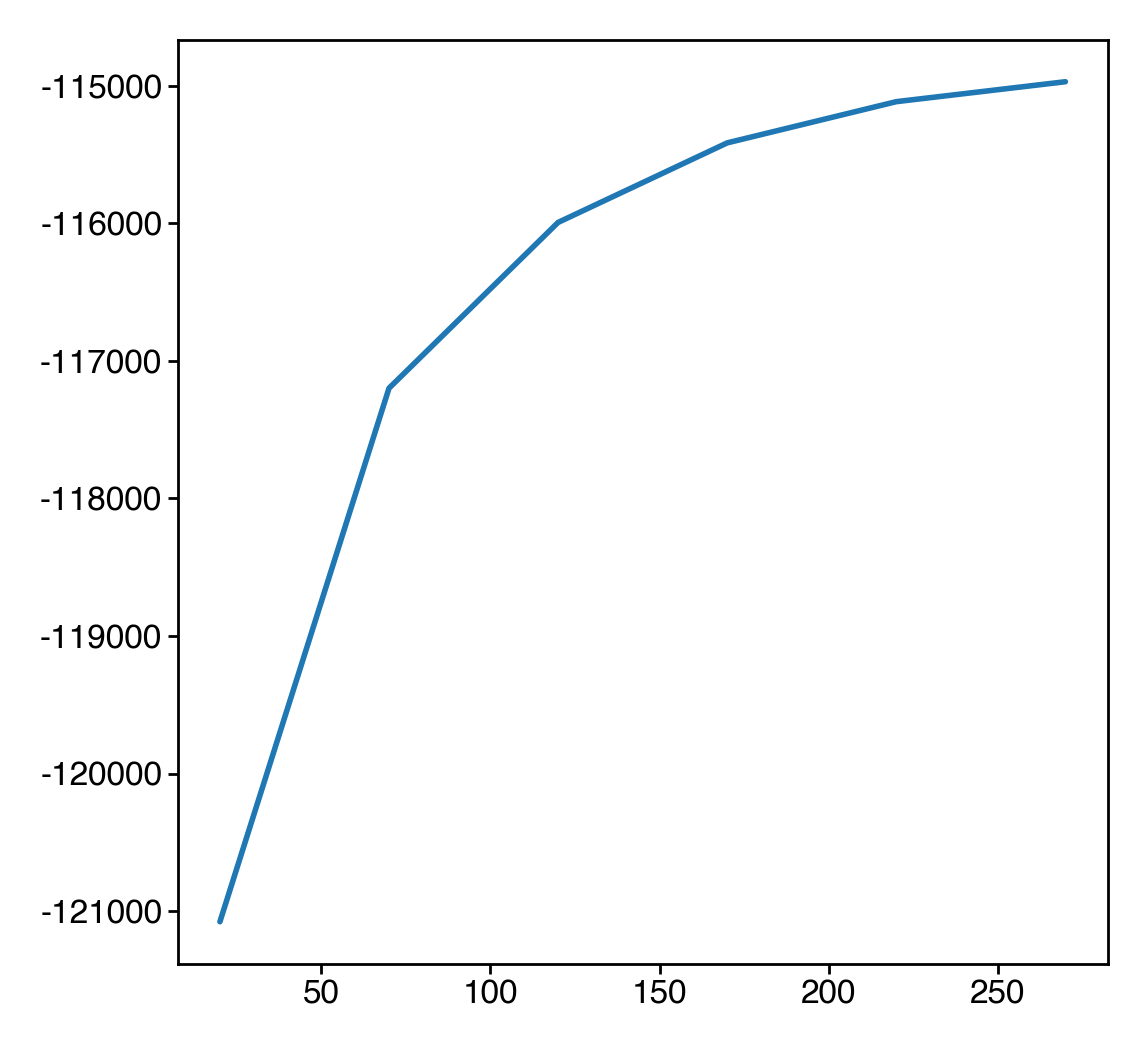

In [15]:
plt.plot(range(20, 300, 50), ll)

In [22]:
out = fit_model(features, hypparams, model_version=1)

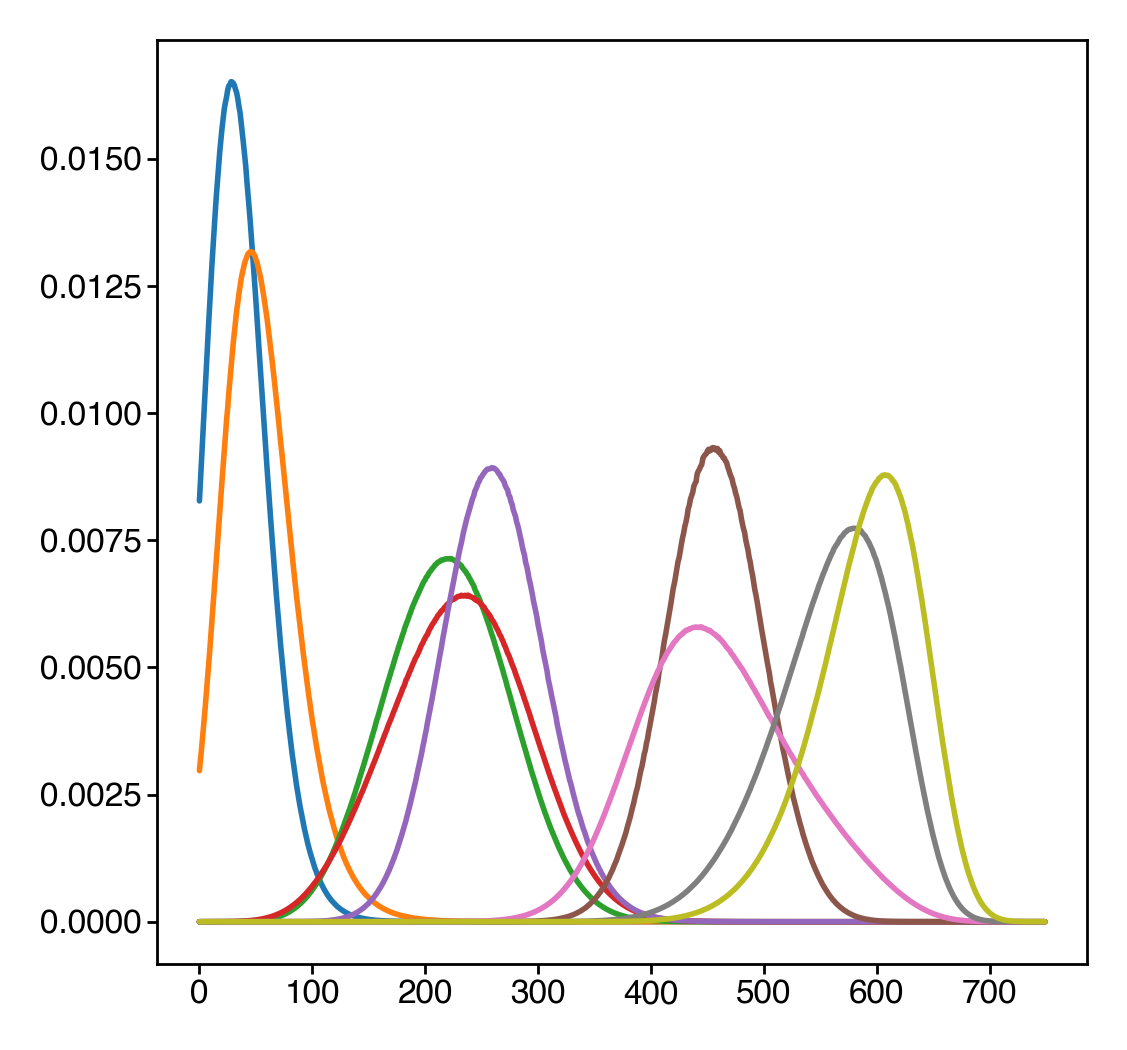

In [23]:
plt.plot(out['age_likelihoods'][::40].T)

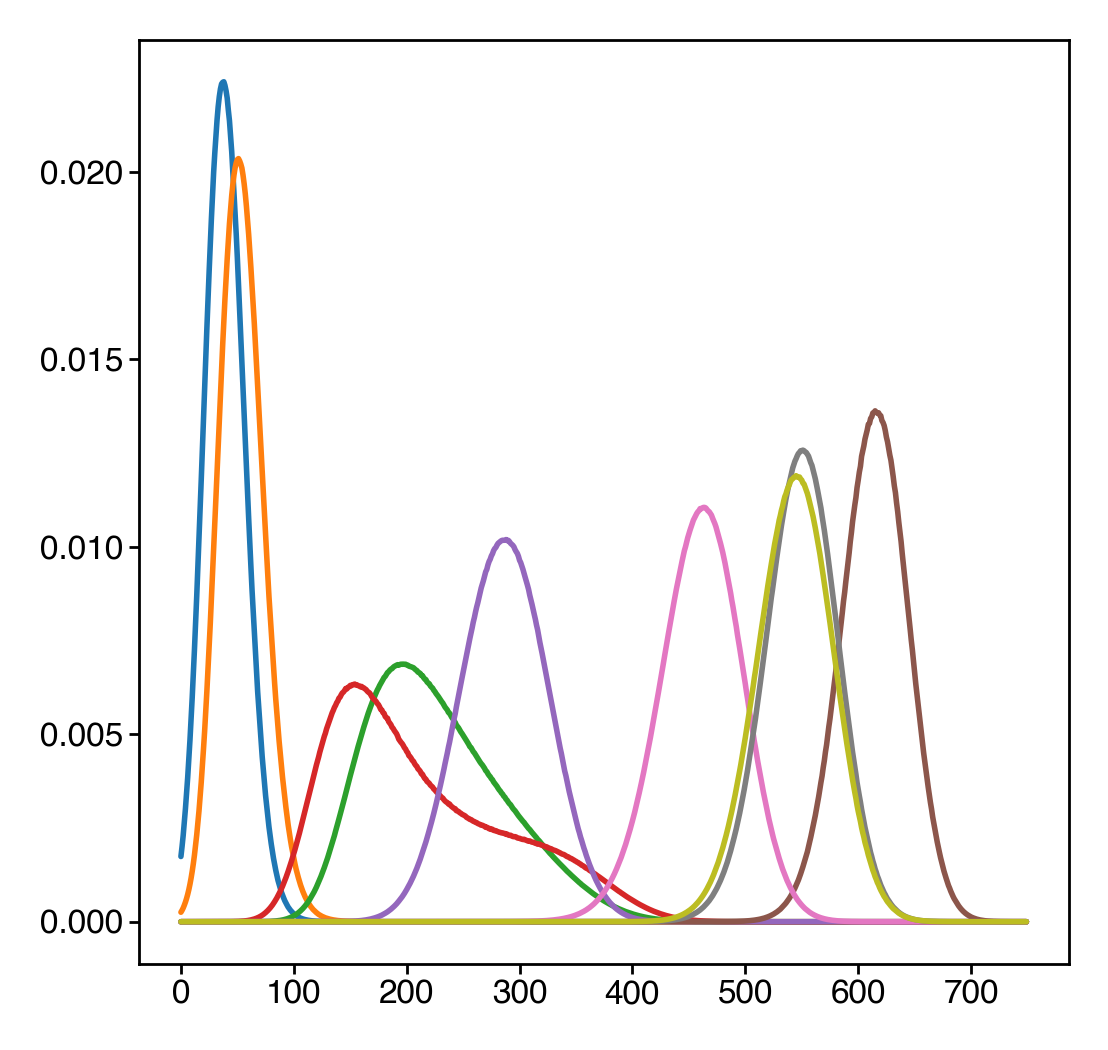

In [14]:
plt.plot(out['age_likelihoods'][::40].T)

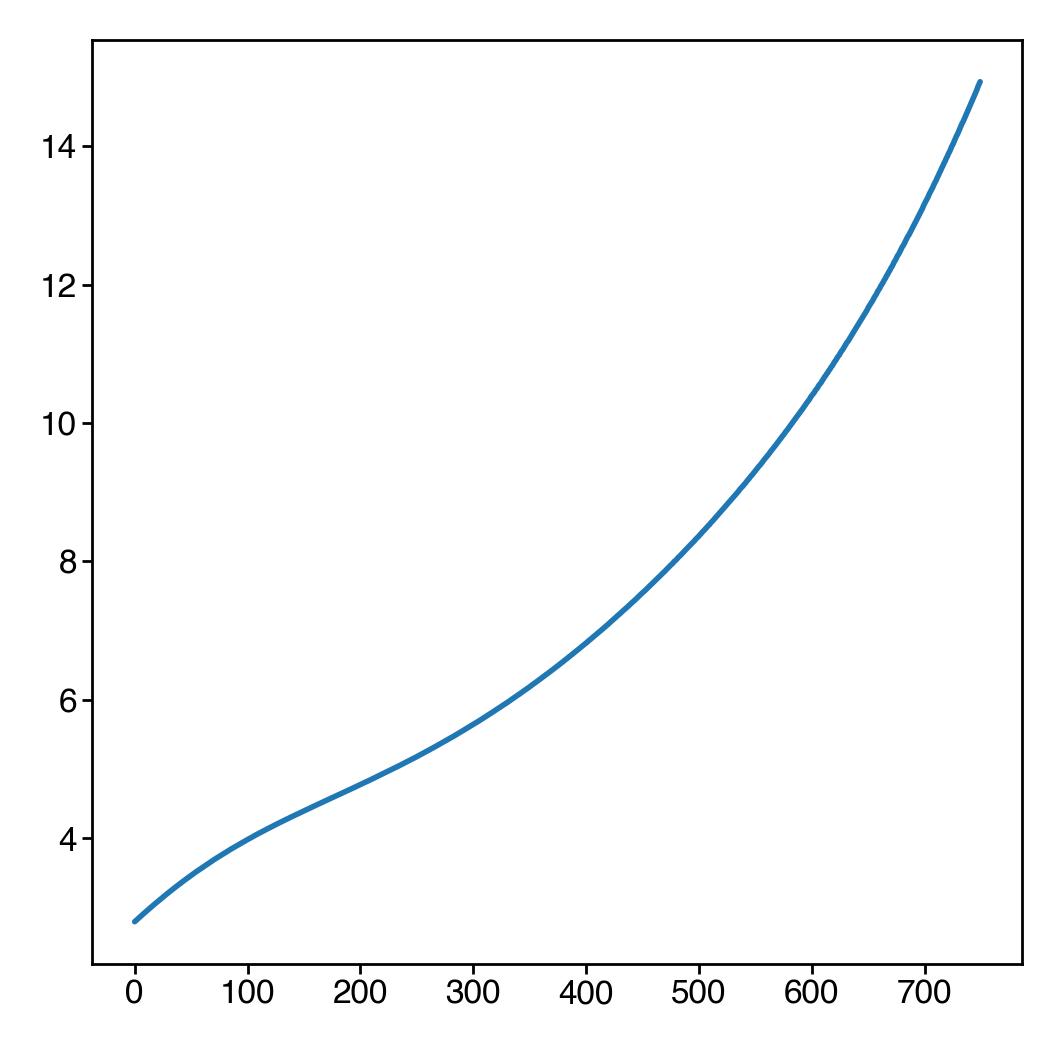

In [18]:
plt.plot(out['concentrations'][0, :, sort_idx[0]])

In [10]:
out['r2_total']

0.5275198180784362

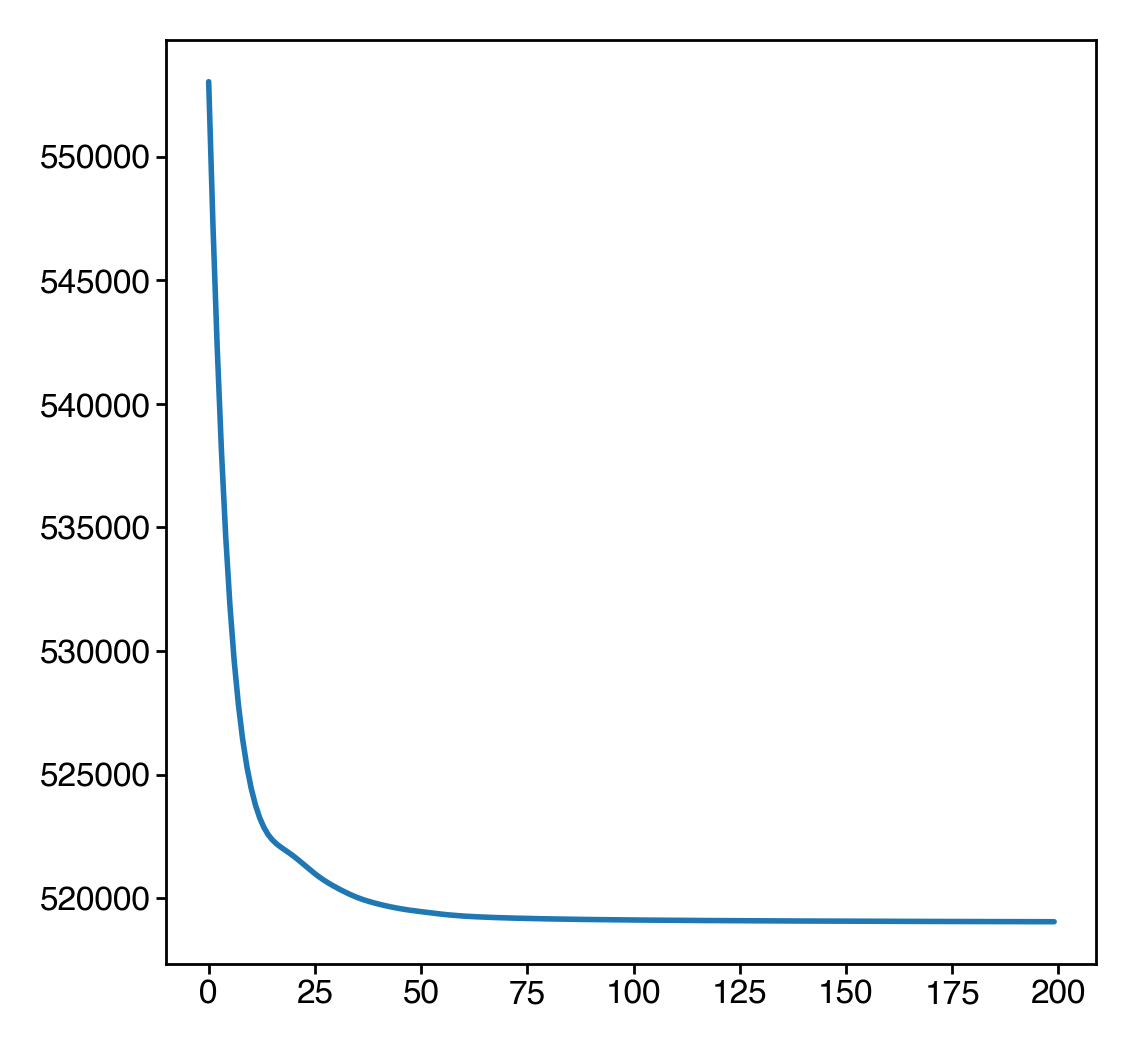

In [11]:
plt.plot(out['loss'])

In [12]:
c = out['counts']
pc = out['predicted_counts']

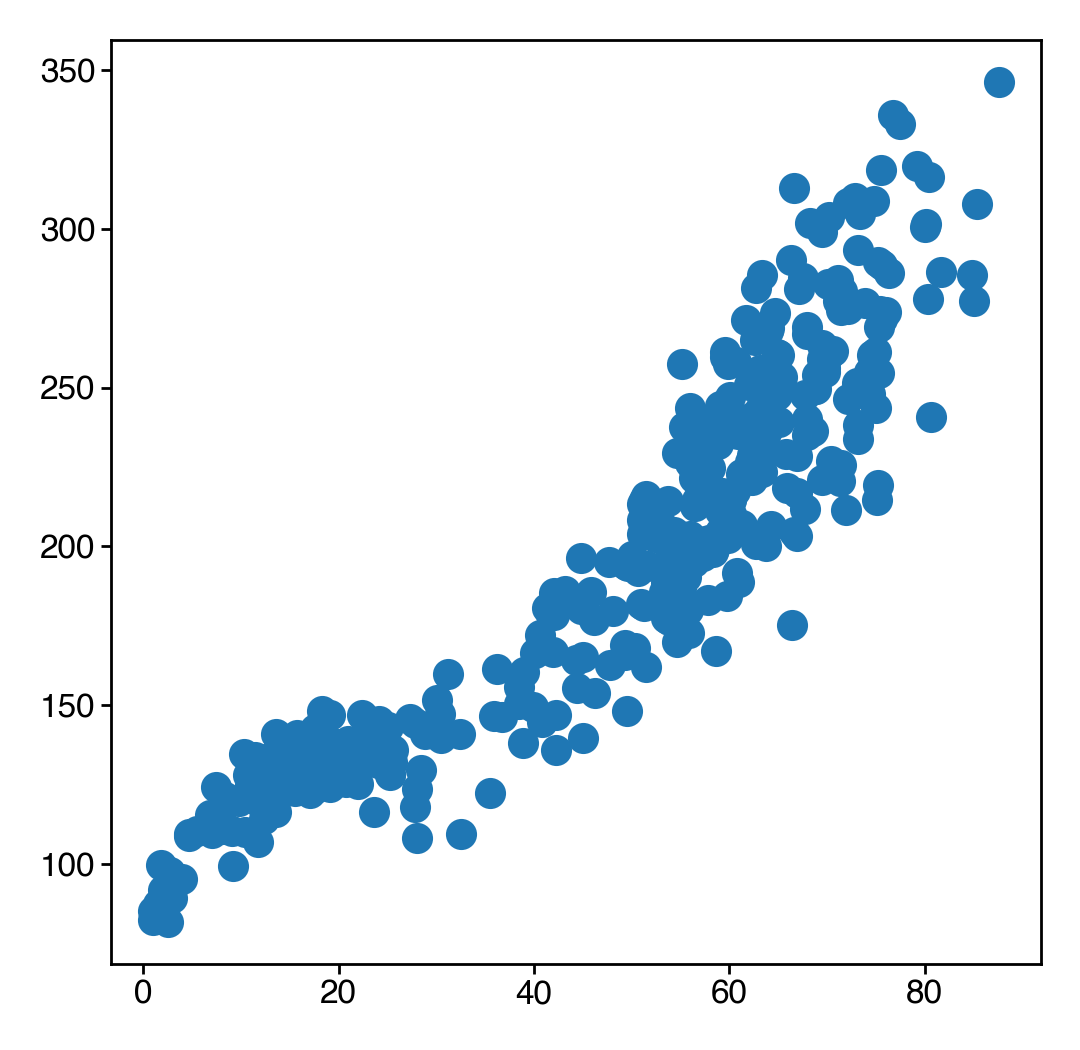

In [13]:
plt.scatter(out['bio_ages'], pc[:, sort_idx[0]])

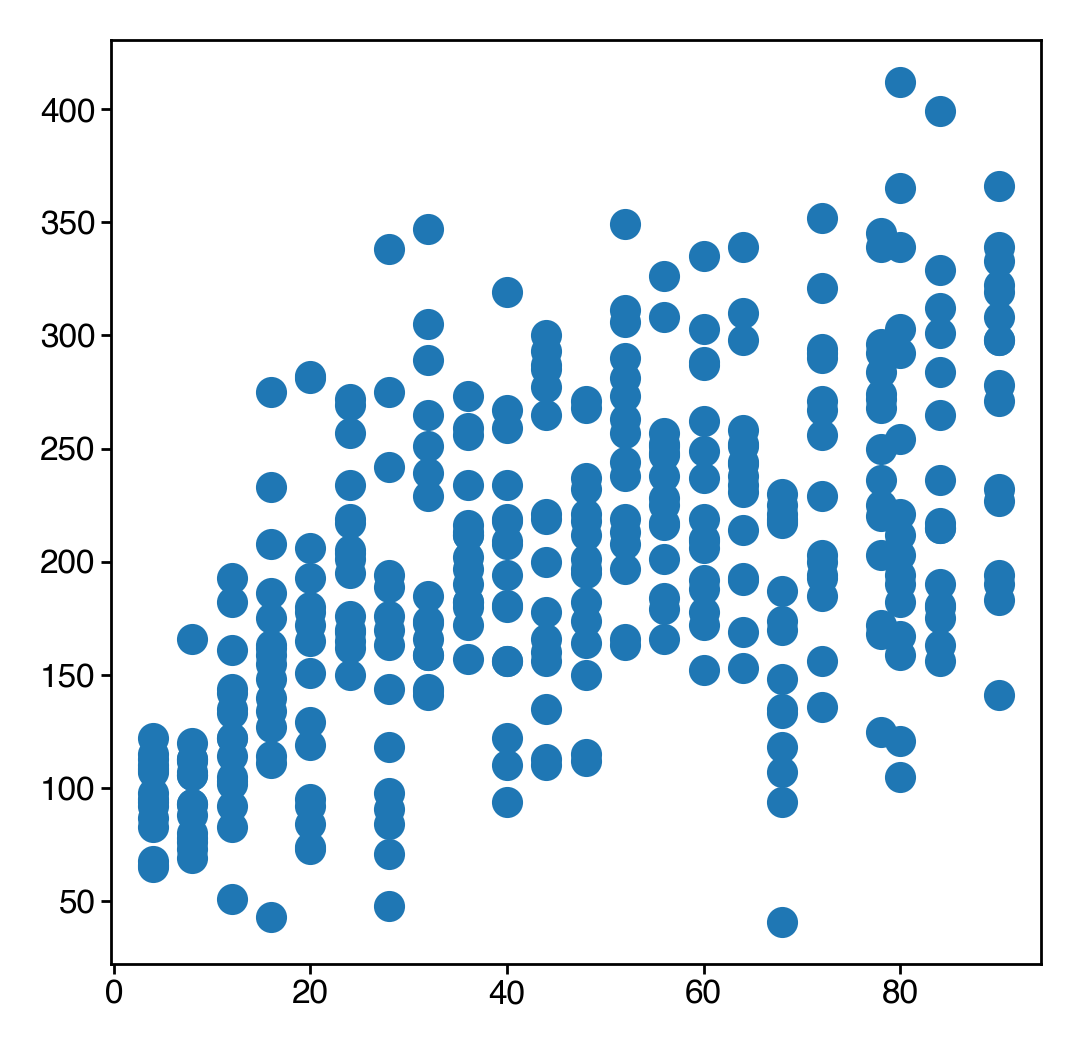

In [14]:
plt.scatter(out['true_ages'], c[:, sort_idx[0]])

## Fit scale

In [24]:
out = []
for _scale in tqdm(np.linspace(1, 200, 15)):
    hypparams["scale"] = float(_scale)
    tmp = masked_xval(features, hypparams, 1, n_repeats=4, disable_tqdm=True)

    tmp["grid_params"] = keyfilter(
        lambda k: k in ["scale"], hypparams
    )
    heldout_ll = list(
        pluck("heldout_ll", keyfilter(lambda k: isinstance(k, int), tmp).values())
    )
    heldout_ll = np.mean(heldout_ll)
    heldout_r2 = list(
        pluck(
            "heldout_r2_total_v3", keyfilter(lambda k: isinstance(k, int), tmp).values()
        )
    )
    heldout_r2 = np.mean(heldout_r2)
    param_norm = np.mean(
        [
            np.linalg.norm(v["params"]["bio_basis_weights"], axis=1).mean()
            for v in keyfilter(lambda k: isinstance(k, int), tmp).values()
        ]
    )
    out.append(
        {
            **tmp["grid_params"],
            "param_norm": param_norm,
            "heldout_ll": heldout_ll,
            "heldout_r2": heldout_r2,
        }
    )
out = pd.DataFrame(out)

  0%|          | 0/15 [00:00<?, ?it/s]

In [56]:
out.set_index('scale')['heldout_ll'].idxmax()

300.5

<Axes: xlabel='scale'>

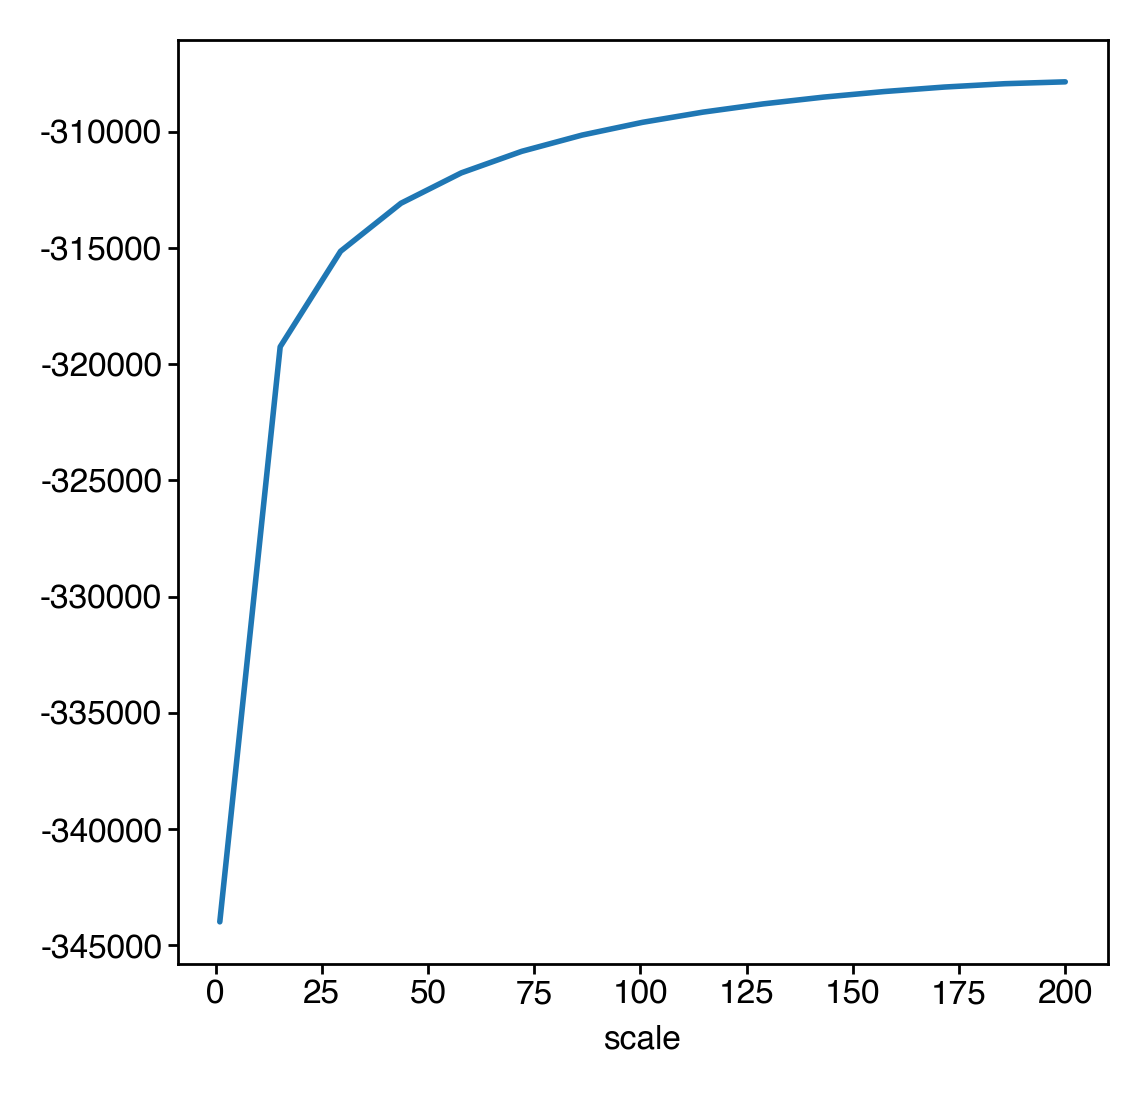

In [25]:
out.set_index('scale')['heldout_ll'].plot()

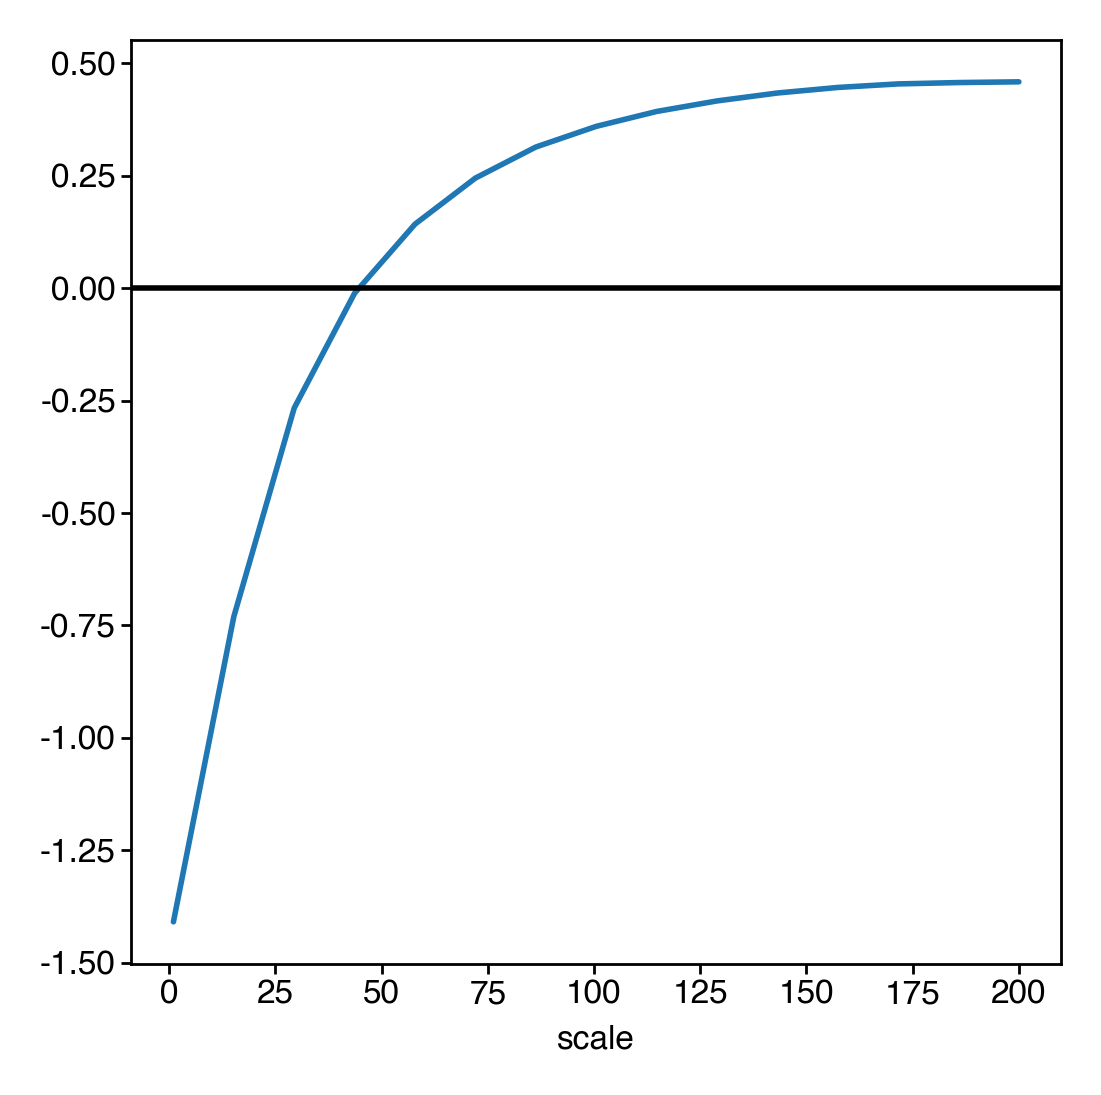

In [27]:
ax = out.set_index('scale')['heldout_r2'].plot()
ax.axhline(0, color='k')

In [28]:
out.set_index('scale').sort_values('heldout_r2', ascending=False)

,param_norm,heldout_ll,heldout_r2
scale,,,
200.000000,2.309786,-307849.25,0.458699
185.785714,2.378623,-307929.75,0.457092
171.571429,2.404213,-308073.50,0.454063
157.357143,2.372832,-308267.75,0.446188
143.142857,2.311661,-308506.50,0.433826
128.928571,2.227916,-308798.00,0.416209
114.714286,2.117376,-309153.75,0.392779
100.500000,1.975965,-309592.00,0.359617
86.285714,1.800975,-310140.25,0.313660


## Fit age sd

In [ ]:
hypparams['scale'] = 110

out = []
for _age_sd in tqdm(np.linspace(1, 40, 6)):
    hypparams["age_sd"] = float(_age_sd)
    tmp = masked_xval(features, hypparams, 1, n_repeats=3, disable_tqdm=True)
    tmp["grid_params"] = keyfilter(
        lambda k: k in ["n_splines", "age_sd"], hypparams
    )
    heldout_ll = list(
        pluck("heldout_ll", keyfilter(lambda k: isinstance(k, int), tmp).values())
    )
    heldout_ll = np.mean(heldout_ll)
    heldout_r2 = list(
        pluck(
            "heldout_r2_total_v3", keyfilter(lambda k: isinstance(k, int), tmp).values()
        )
    )
    heldout_r2 = np.mean(heldout_r2)
    param_norm = np.mean(
        [
            np.linalg.norm(v["params"]["bio_basis_weights"], axis=1).mean()
            for v in keyfilter(lambda k: isinstance(k, int), tmp).values()
        ]
    )
    out.append(
        {
            **tmp["grid_params"],
            "param_norm": param_norm,
            "heldout_ll": heldout_ll,
            "heldout_r2": heldout_r2,
        }
    )
out = pd.DataFrame(out)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
ax = out.set_index('age_sd')['heldout_ll'].plot()

In [ ]:
ax = out.set_index('age_sd')['heldout_r2'].plot()

In [82]:
out = []
for _age_sd in tqdm(np.linspace(4, 16, 16)):
    hypparams["age_sd"] = float(_age_sd)
    tmp = masked_xval(features, hypparams, 2, n_repeats=3, disable_tqdm=True)
    tmp["grid_params"] = keyfilter(
        lambda k: k in ["n_splines", "age_sd"], hypparams
    )
    heldout_ll = list(
        pluck("heldout_ll", keyfilter(lambda k: isinstance(k, int), tmp).values())
    )
    heldout_ll = np.mean(heldout_ll)
    heldout_r2 = list(
        pluck(
            "heldout_r2_total_v3", keyfilter(lambda k: isinstance(k, int), tmp).values()
        )
    )
    heldout_r2 = np.mean(heldout_r2)
    param_norm = np.mean(
        [
            np.linalg.norm(v["params"]["bio_basis_weights"], axis=1).mean()
            for v in keyfilter(lambda k: isinstance(k, int), tmp).values()
        ]
    )
    out.append(
        {
            **tmp["grid_params"],
            "param_norm": param_norm,
            "heldout_ll": heldout_ll,
            "heldout_r2": heldout_r2,
        }
    )
out = pd.DataFrame(out)

  0%|          | 0/16 [00:00<?, ?it/s]

<Axes: xlabel='age_sd'>

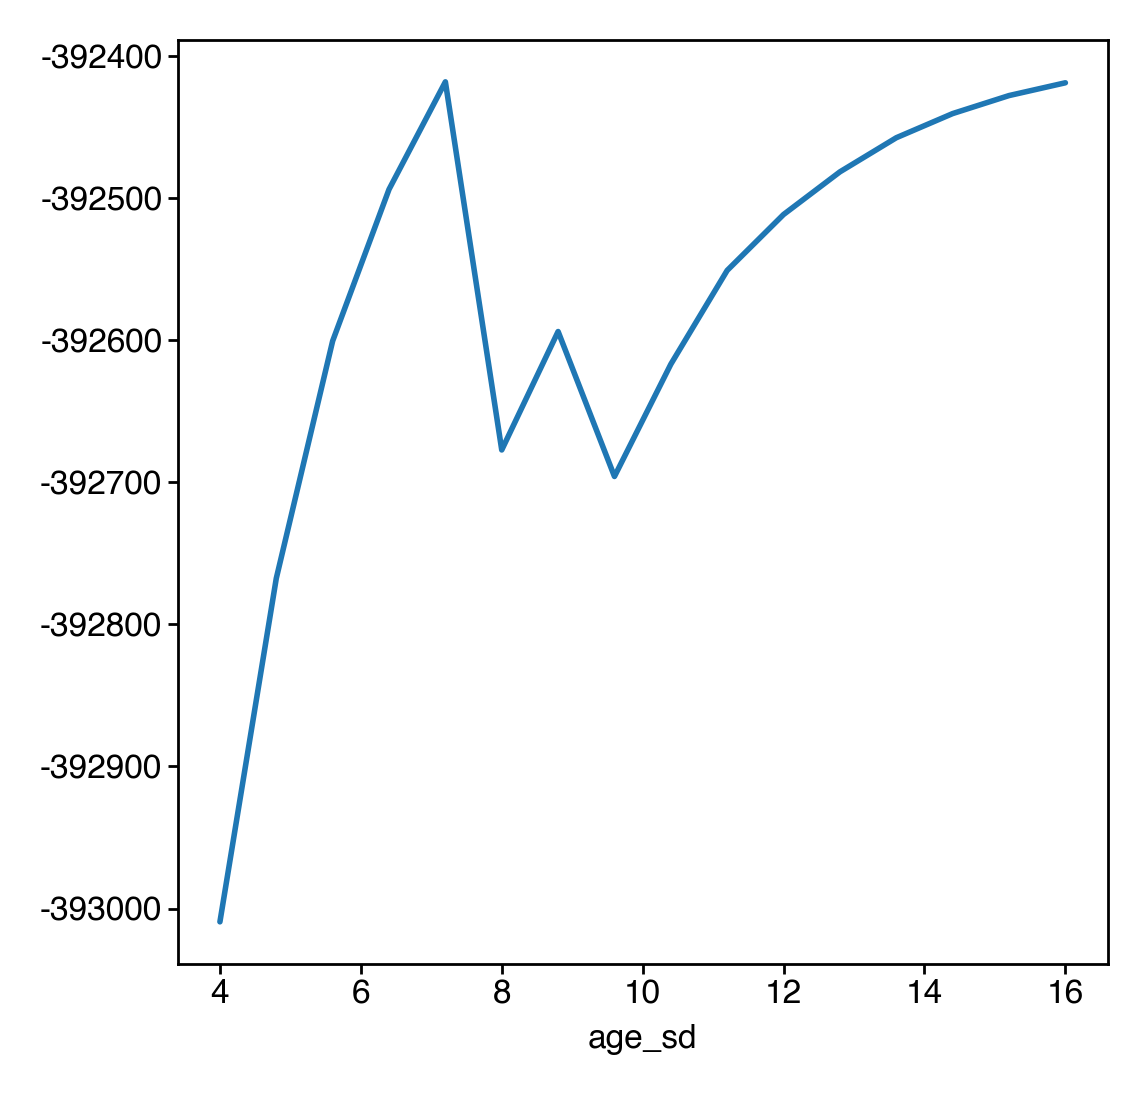

In [83]:
out.set_index('age_sd')['heldout_ll'].plot()

In [92]:
out.sort_values(by='heldout_ll', ascending=False)

,age_sd,n_splines,param_norm,heldout_ll,heldout_r2
2,11.0,14,3.021144,-397157.666667,0.434437
3,16.0,14,2.932214,-397181.333333,0.439300
1,6.0,14,3.805318,-397189.666667,0.405841
4,21.0,14,2.816564,-397221.666667,0.439211
5,26.0,14,2.780521,-397255.666667,0.442449
6,31.0,14,2.733853,-397299.666667,0.441568
7,36.0,14,2.660285,-397331.333333,0.444458
8,41.0,14,2.702270,-397372.000000,0.444061
9,46.0,14,2.683295,-397402.000000,0.442360
0,1.0,14,13.937770,-397438.666667,0.200223


In [99]:
out = []

# losses = {}

hypparams["age_sd"] = 11.0
hypparams["scale"] = 100

for n_splines in tqdm(range(4, 11, 3)):
    try:
        hypparams["n_splines"] = n_splines
        tmp = masked_xval(features, hypparams, 1, n_repeats=3, disable_tqdm=True)
        # losses[n_splines] = tmp[0]["loss"]
        tmp["grid_params"] = keyfilter(
            lambda k: k in ["n_splines", "age_sd"], hypparams
        )
        heldout_ll = list(
            pluck("heldout_ll", keyfilter(lambda k: isinstance(k, int), tmp).values())
        )
        heldout_ll = np.mean(heldout_ll)
        heldout_r2 = list(
            pluck(
                "heldout_r2_total_v3",
                keyfilter(lambda k: isinstance(k, int), tmp).values(),
            )
        )
        heldout_r2 = np.mean(heldout_r2)
        param_norm = np.mean(
            [
                np.linalg.norm(v["params"]["bio_basis_weights"], axis=1).mean()
                for v in keyfilter(lambda k: isinstance(k, int), tmp).values()
            ]
        )
        out.append(
            {
                **tmp["grid_params"],
                "param_norm": param_norm,
                "heldout_ll": heldout_ll,
                "heldout_r2": heldout_r2,
            }
        )
    except ValueError:
        continue

out = pd.DataFrame(out)

  0%|          | 0/3 [00:00<?, ?it/s]

In [100]:
# out = pd.DataFrame(out)

<Axes: xlabel='n_splines'>

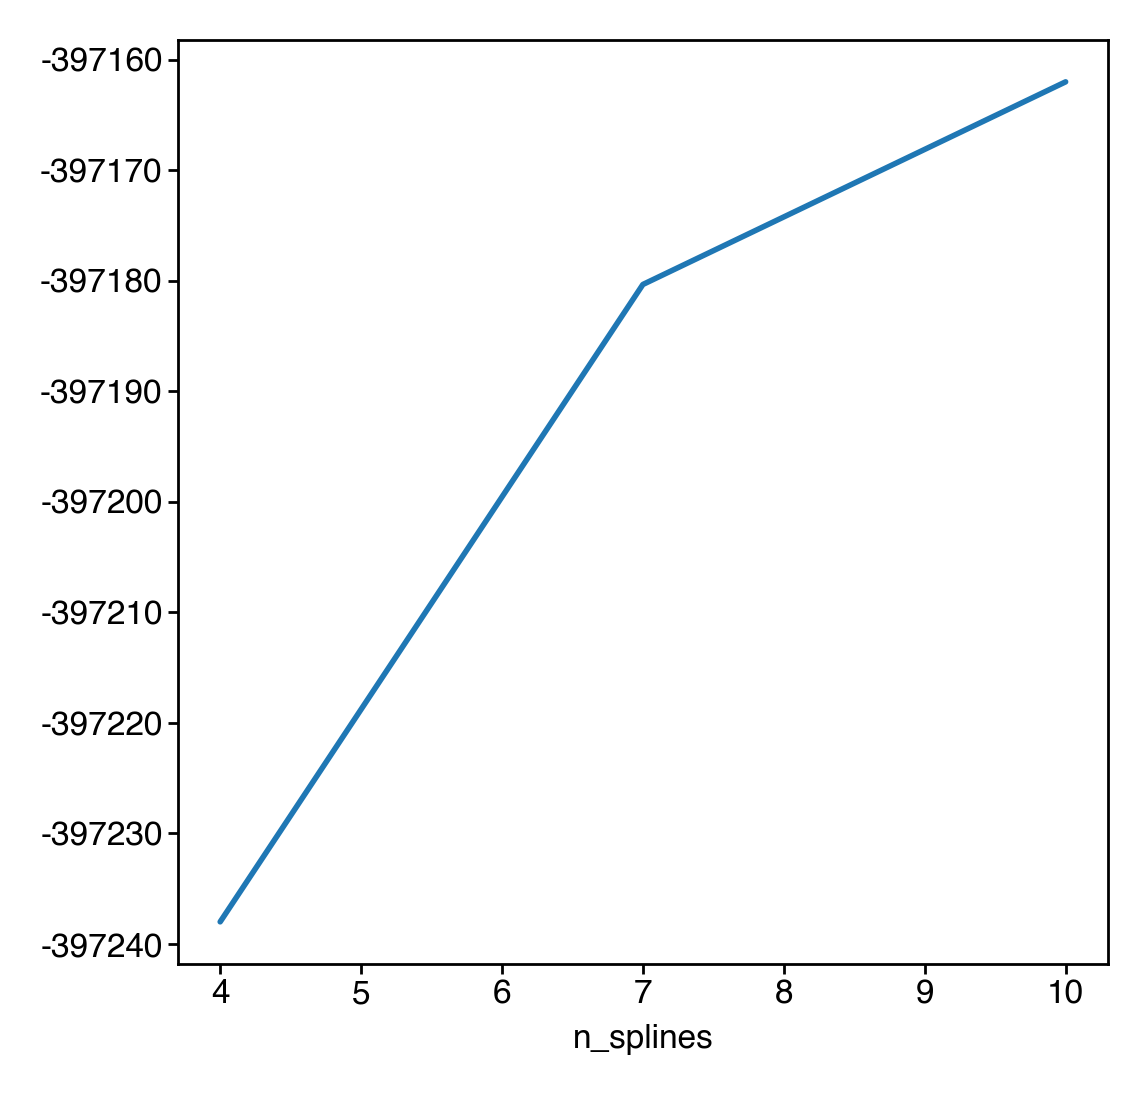

In [101]:
out.set_index('n_splines')['heldout_ll'].plot()

<Axes: xlabel='n_splines'>

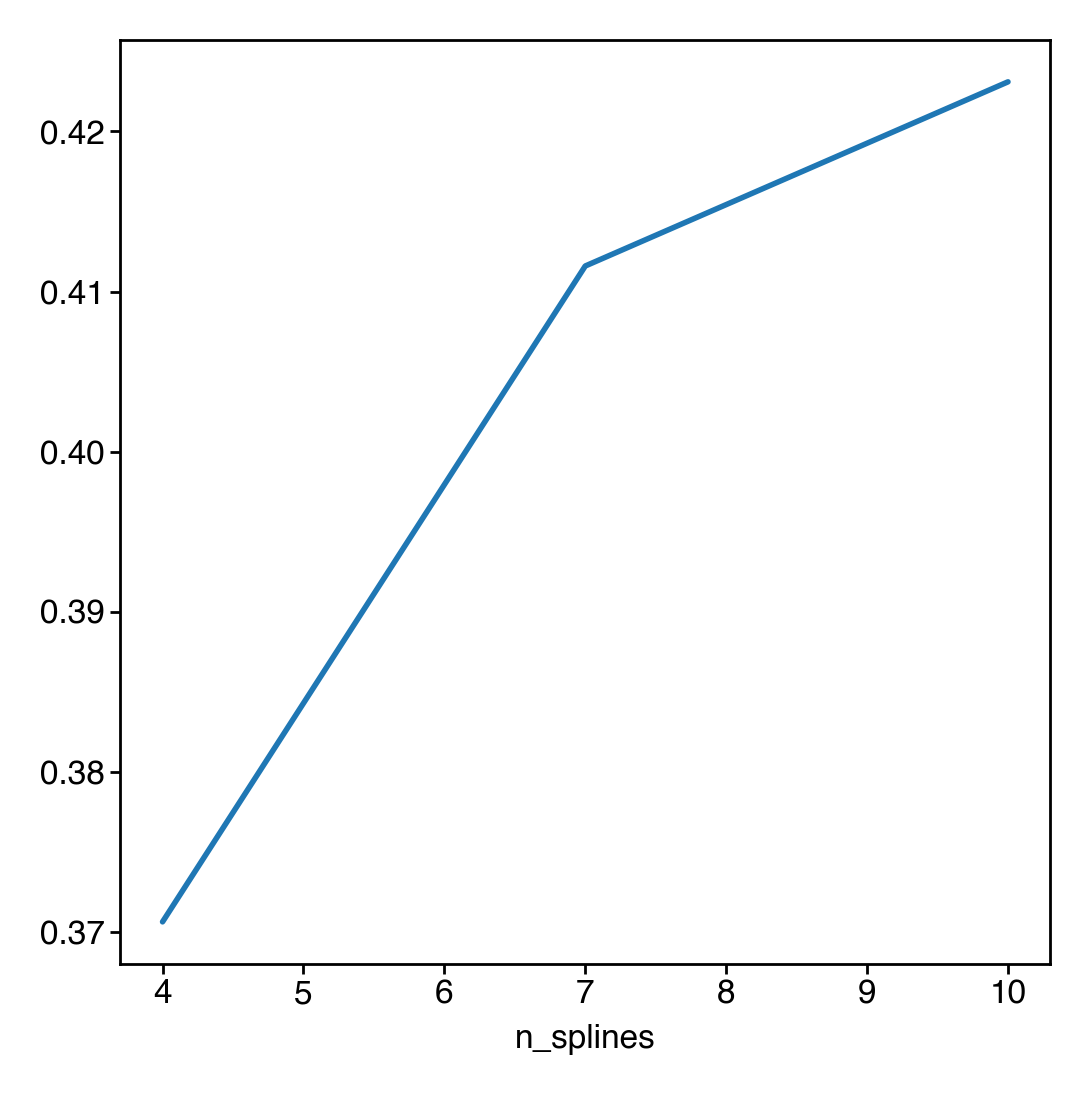

In [102]:
out.set_index('n_splines')['heldout_r2'].plot()

In [103]:
out.set_index('n_splines').sort_values(by='heldout_r2', ascending=False)

,age_sd,param_norm,heldout_ll,heldout_r2
n_splines,,,,
10,11.0,2.488703,-397162.000000,0.423095
7,11.0,2.114586,-397180.333333,0.411594
4,11.0,2.043784,-397238.000000,0.370636


In [104]:
out.set_index('n_splines').sort_values(by='heldout_ll', ascending=False)

,age_sd,param_norm,heldout_ll,heldout_r2
n_splines,,,,
10,11.0,2.488703,-397162.000000,0.423095
7,11.0,2.114586,-397180.333333,0.411594
4,11.0,2.043784,-397238.000000,0.370636


In [122]:
hypparams['n_splines'] = 5
hypparams['scale'] = 50
hypparams['age_sd'] = 9
tmp = fit_model(features, hypparams, model_version=1)

In [123]:
list(tmp)

['params',
 'heldout_ll',
 'loss',
 'bio_ages',
 'true_ages',
 'init_components',
 'concentrations',
 'concentration_components',
 'predicted_counts',
 'counts',
 'r2_total',
 'r2_each',
 'heldout_r2_total_v2',
 'heldout_r2_total_v3']

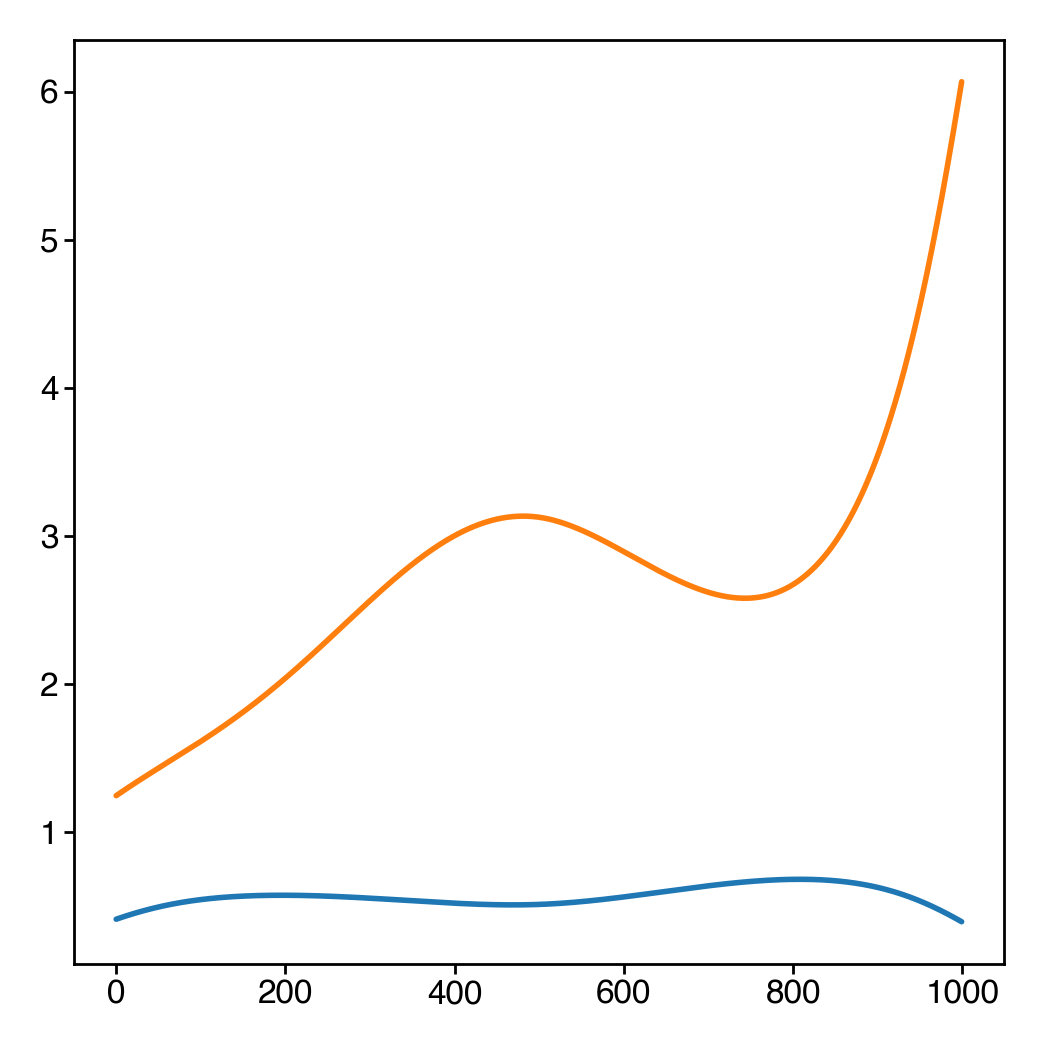

In [124]:
plt.plot(tmp['concentrations'][0, :, 0])
plt.plot(tmp['concentrations'][0, :, 3])

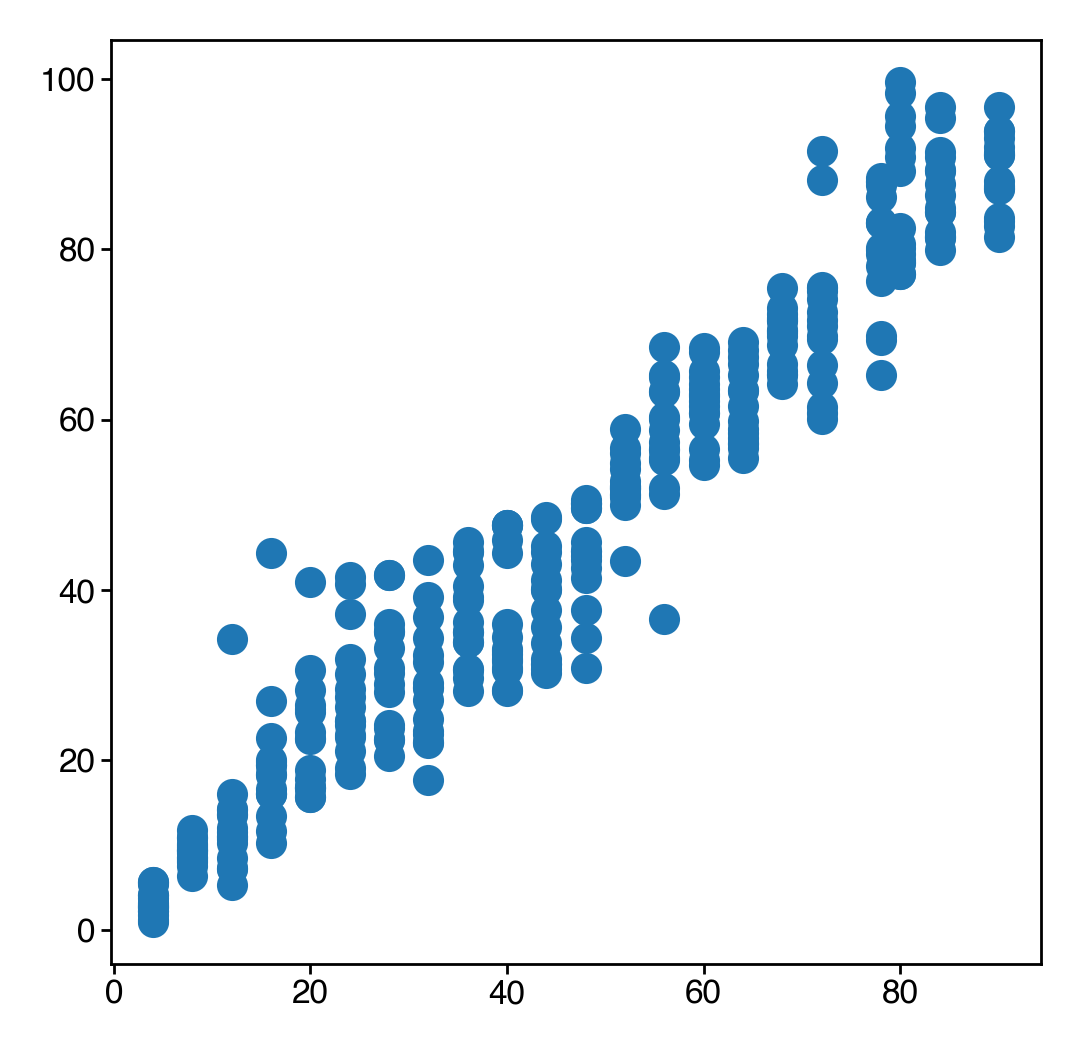

In [125]:
plt.scatter(tmp['true_ages'], tmp['bio_ages'])

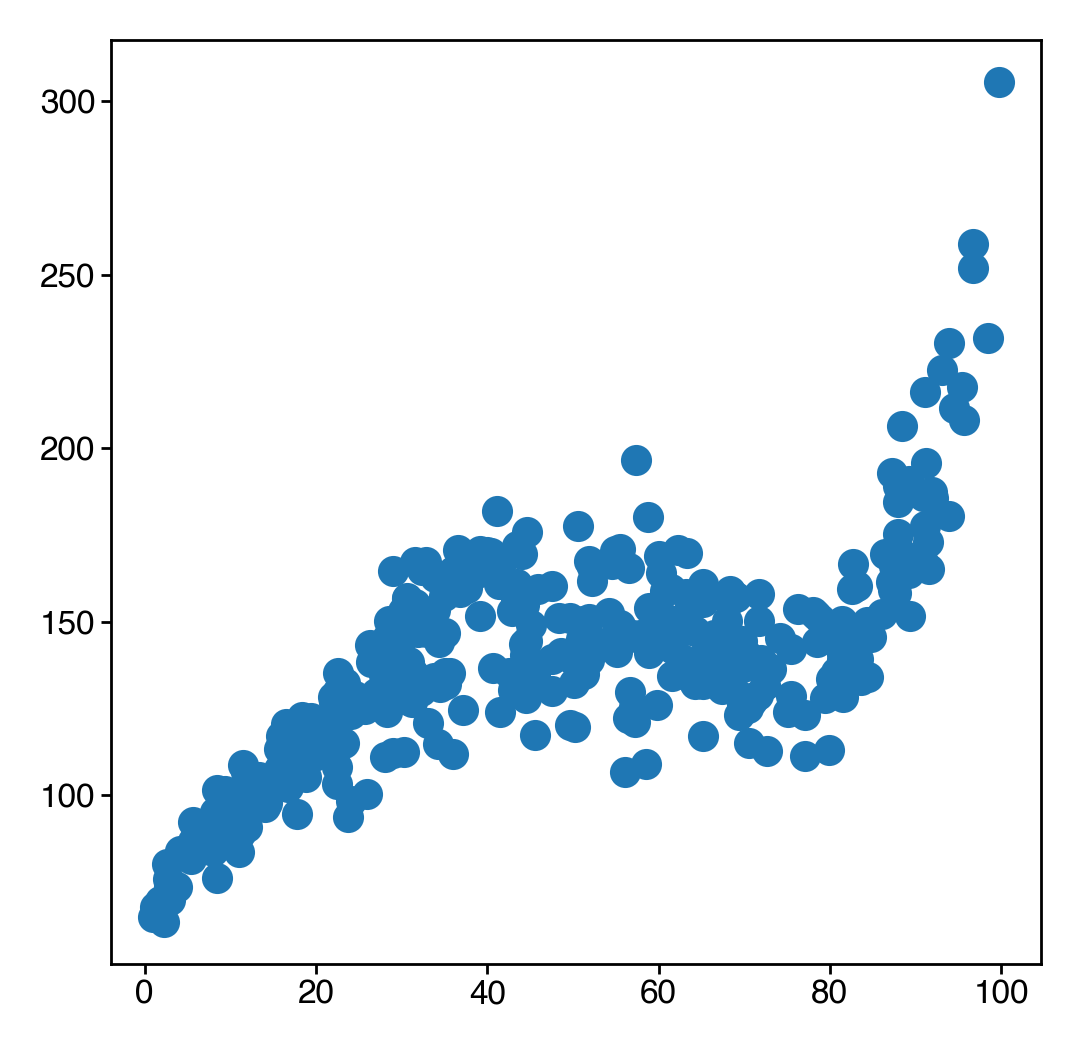

In [127]:
plt.scatter(tmp['bio_ages'], tmp['predicted_counts'][:, sort_idx[0]])

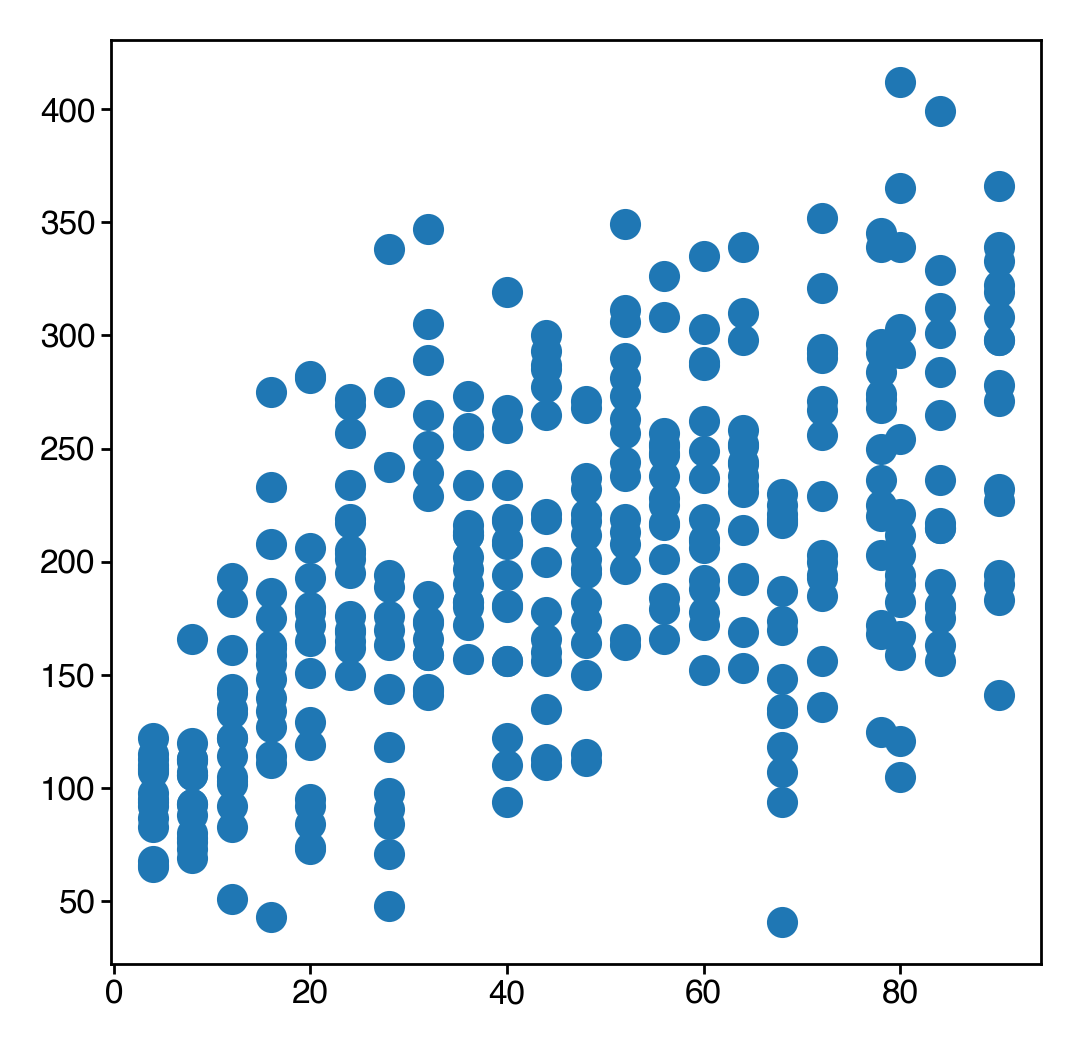

In [121]:
plt.scatter(tmp['true_ages'], tmp['counts'][:, sort_idx[0]])

In [25]:
out = []

# losses = {}

hypparams["age_sd"] = 7.0

for n_splines in tqdm(range(6, 14, 1)):
    try:
        hypparams["n_splines"] = n_splines
        tmp = masked_xval(features, hypparams, 2, n_repeats=2, disable_tqdm=True)
        # losses[n_splines] = tmp[0]["loss"]
        tmp["grid_params"] = keyfilter(
            lambda k: k in ["n_splines", "age_sd"], hypparams
        )
        heldout_ll = list(
            pluck("heldout_ll", keyfilter(lambda k: isinstance(k, int), tmp).values())
        )
        heldout_ll = np.mean(heldout_ll)
        heldout_r2 = list(
            pluck(
                "heldout_r2_total_v3",
                keyfilter(lambda k: isinstance(k, int), tmp).values(),
            )
        )
        heldout_r2 = np.mean(heldout_r2)
        param_norm = np.mean(
            [
                np.linalg.norm(v["params"]["bio_basis_weights"], axis=1).mean()
                for v in keyfilter(lambda k: isinstance(k, int), tmp).values()
            ]
        )
        out.append(
            {
                **tmp["grid_params"],
                "param_norm": param_norm,
                "heldout_ll": heldout_ll,
                "heldout_r2": heldout_r2,
            }
        )
    except ValueError:
        continue

out = pd.DataFrame(out)

  0%|          | 0/8 [00:00<?, ?it/s]

<Axes: xlabel='n_splines'>

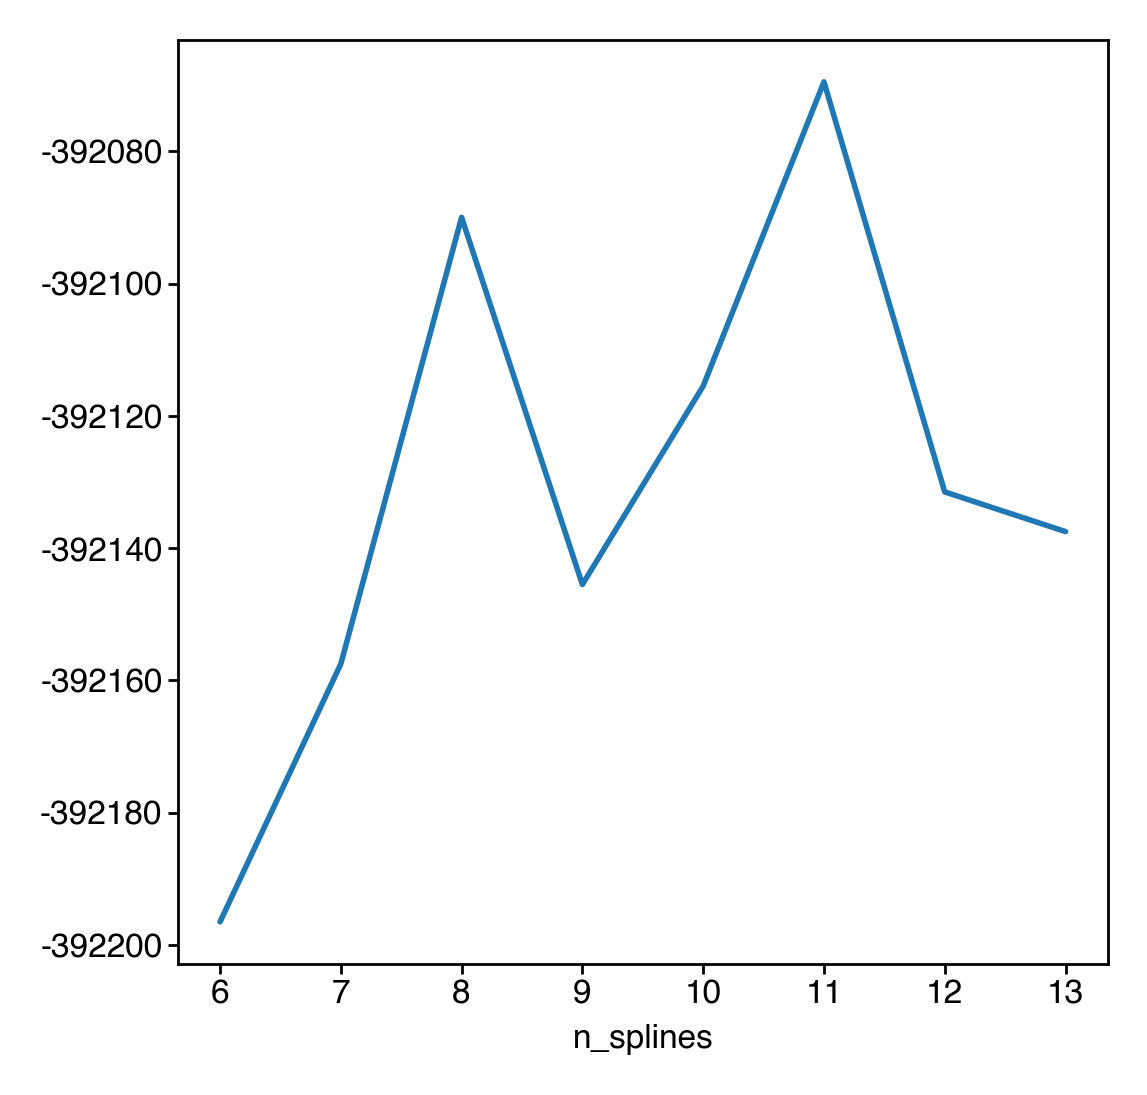

In [26]:
out.set_index('n_splines')['heldout_ll'].plot()

<Axes: xlabel='n_splines'>

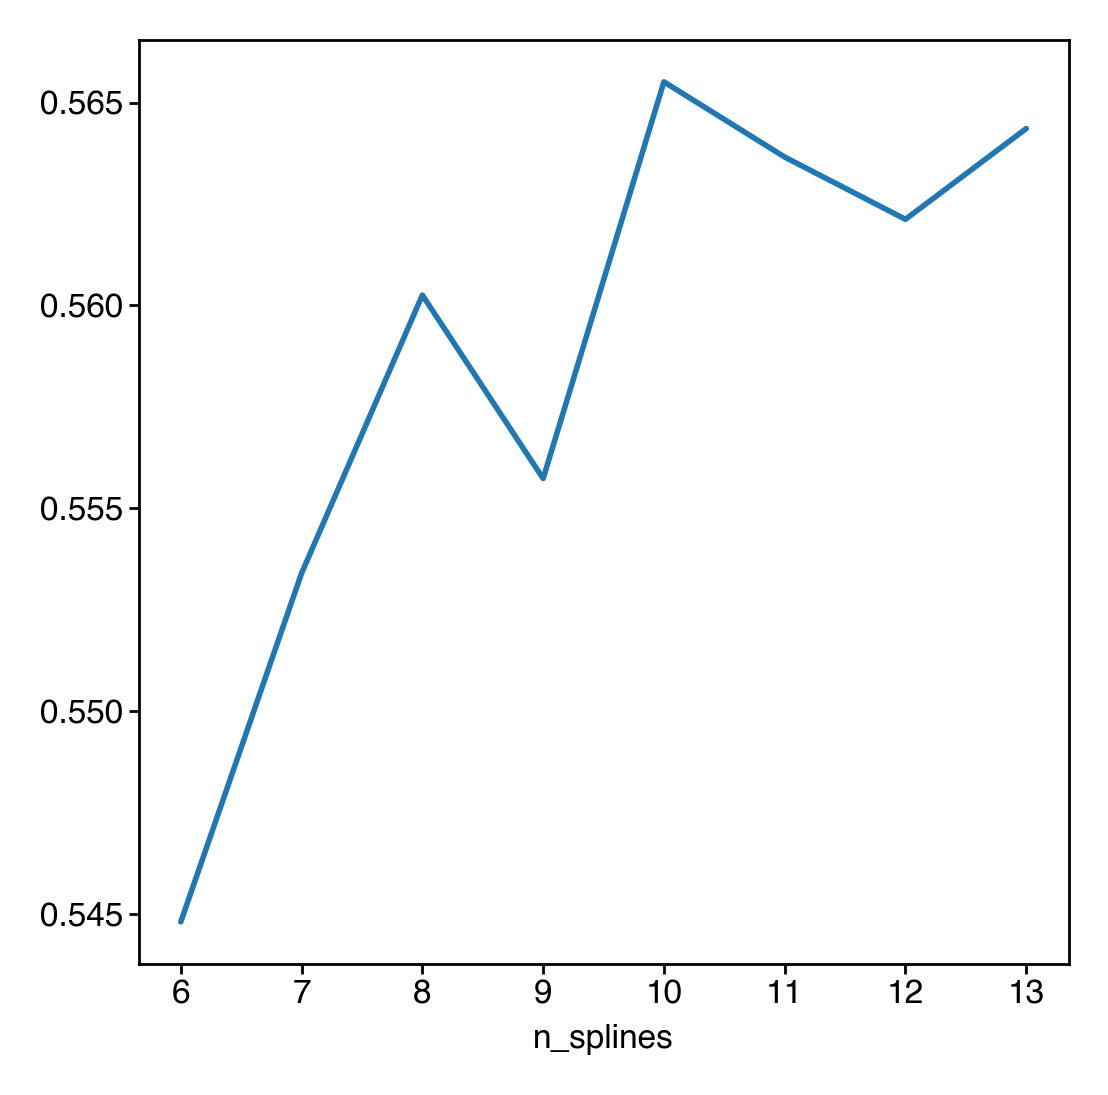

In [27]:
out.set_index('n_splines')['heldout_r2'].plot()

In [ ]:
hypparams['n_splines'] = 11
tmp = masked_xval(features, hypparams, 2, n_repeats=2, disable_tqdm=True)


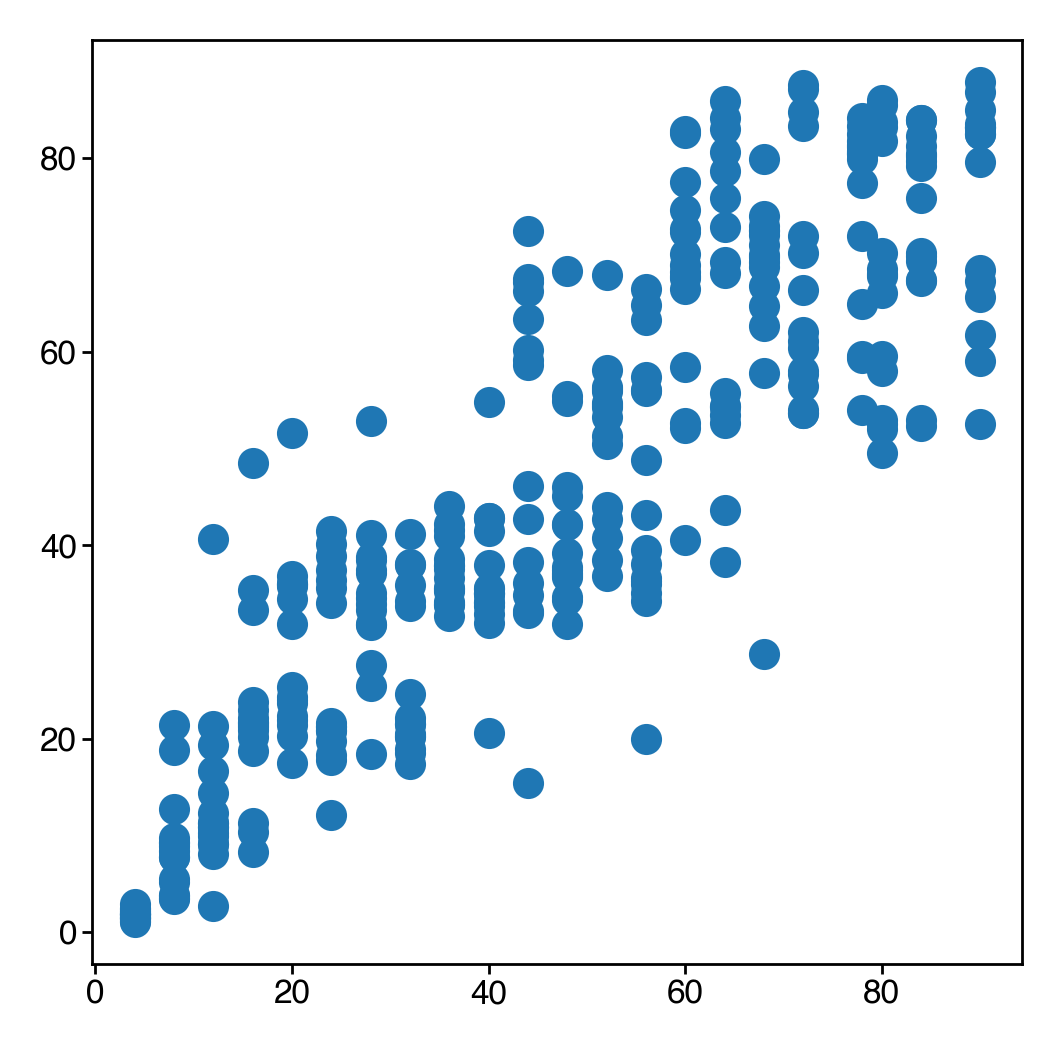

In [31]:
plt.scatter(tmp[0]['true_ages'], tmp[0]['bio_ages'])

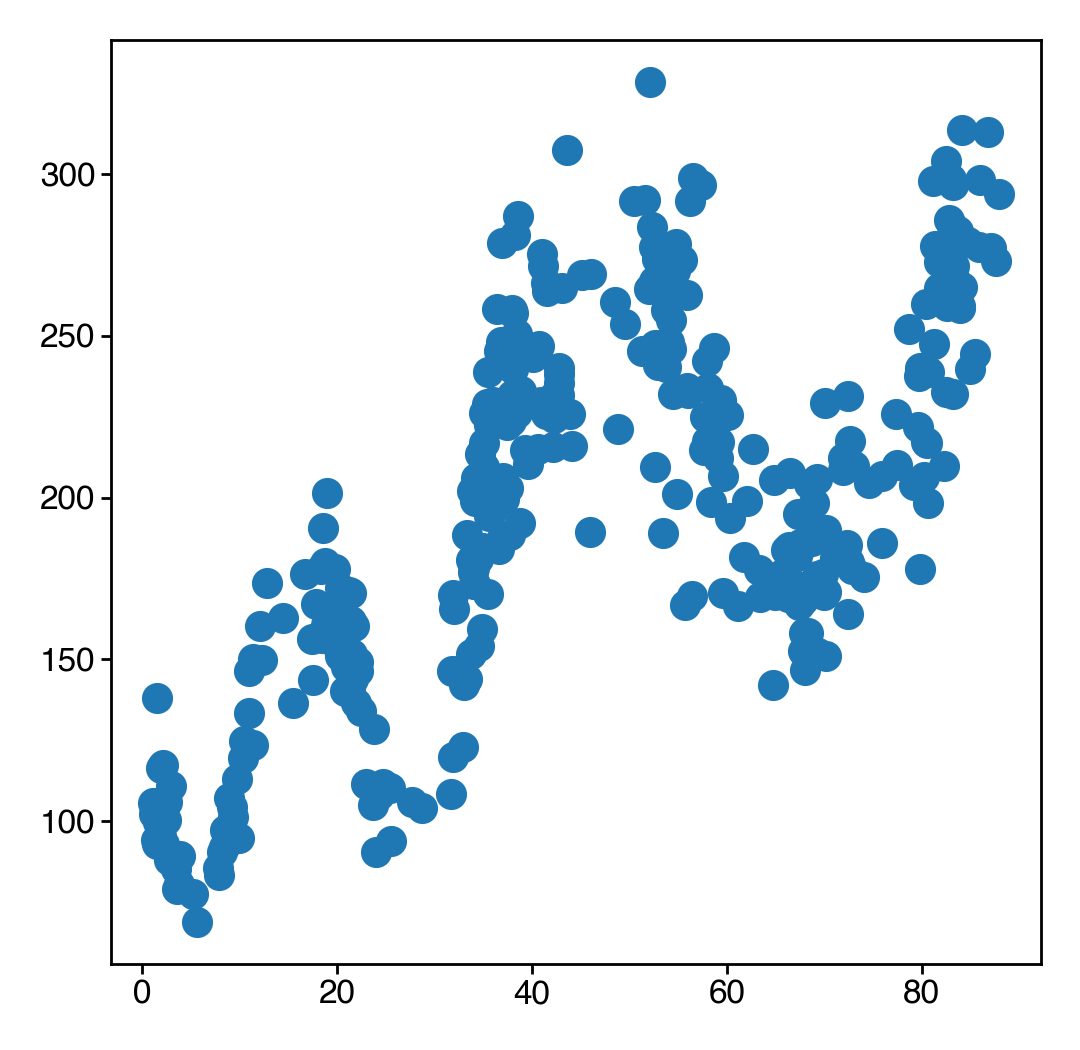

In [32]:
plt.scatter(tmp[0]['bio_ages'], tmp[0]['predicted_counts'][:, 0])

## Try splitting the data into smaller sizes - what happens to the held-out spline optimization? Does it increase?

In [55]:
from sklearn.model_selection import StratifiedKFold
from toolz import first, take

In [65]:
folds = [1/3, 2, 5, 16]

hypparams = {
    "min_age": 1,
    "max_age": 100,
    "age_sd": 7,  # weeks
    # "bio_params_sd": 3,
    "size_params_sd": 1000,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_size_splines": 5,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_keep_sylls": 25,
    # "n_sessions": len(train),
    "lr": 0.1,
    "n_opt_iter": 125,
    "use_rw_prior": False,
    "rw_sd": 100,
}
out = []

for fold in tqdm(folds[::-1], desc="Looping through folds"):
    new_fold = fold if fold > 1 else int(1 / fold)
    for fold_num, (train, test) in enumerate(take(2, StratifiedKFold(new_fold, shuffle=True, random_state=0).split(age, age))):
        if fold < 1:
            train, test = test, train

        features = {
            "ages": age[train],
            "counts": syllable_counts_jax[train] + 1,
            "sizes": sizes_col.to_numpy()[train],
        }
        hypparams["n_sessions"] = len(train)
    
        for n_splines in tqdm(range(4, 12, 2), desc="Looping through splines"):
            try:
                hypparams["n_splines"] = n_splines
                tmp = masked_xval(features, hypparams, 2, n_repeats=2, disable_tqdm=True)
                tmp["grid_params"] = keyfilter(
                    lambda k: k in ["n_splines", "age_sd"], hypparams
                )
                heldout_ll = list(
                    pluck(
                        "heldout_ll", keyfilter(lambda k: isinstance(k, int), tmp).values()
                    )
                )
                heldout_ll = np.mean(heldout_ll) / len(train)
                heldout_r2 = list(
                    pluck(
                        "heldout_r2_total_v3",
                        keyfilter(lambda k: isinstance(k, int), tmp).values(),
                    )
                )
                heldout_r2 = np.mean(heldout_r2)
                param_norm = np.mean(
                    [
                        np.linalg.norm(v["params"]["bio_basis_weights"], axis=1).mean()
                        for v in keyfilter(lambda k: isinstance(k, int), tmp).values()
                    ]
                )
                out.append(
                    {
                        **tmp["grid_params"],
                        "param_norm": param_norm,
                        "heldout_ll": heldout_ll,
                        "heldout_r2": heldout_r2,
                        "n_folds": fold,
                        "fold_num": fold_num,
                    }
                )
            except ValueError:
                continue
    
print(
    pd.DataFrame(out).groupby(['n_folds', 'n_splines'])[['heldout_ll']].mean().groupby("n_folds")["heldout_ll"].idxmax()
)

Looping through folds:   0%|          | 0/4 [00:00<?, ?it/s]

/home/wg41/miniconda3/envs/aging-gpu/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 15 members, which is less than n_splits=16.
  warnings.warn(


Looping through splines:   0%|          | 0/4 [00:00<?, ?it/s]

Looping through splines:   0%|          | 0/4 [00:00<?, ?it/s]

Looping through splines:   0%|          | 0/4 [00:00<?, ?it/s]

Looping through splines:   0%|          | 0/4 [00:00<?, ?it/s]

Looping through splines:   0%|          | 0/4 [00:00<?, ?it/s]

Looping through splines:   0%|          | 0/4 [00:00<?, ?it/s]

Looping through splines:   0%|          | 0/4 [00:00<?, ?it/s]

Looping through splines:   0%|          | 0/4 [00:00<?, ?it/s]

n_folds
0.333333     (0.3333333333333333, 6)
2.000000                    (2.0, 6)
5.000000                    (5.0, 8)
16.000000                 (16.0, 10)
Name: heldout_ll, dtype: object


In [66]:
out = pd.DataFrame(out)

[Text(0, 0.5, 'Heldout LL')]

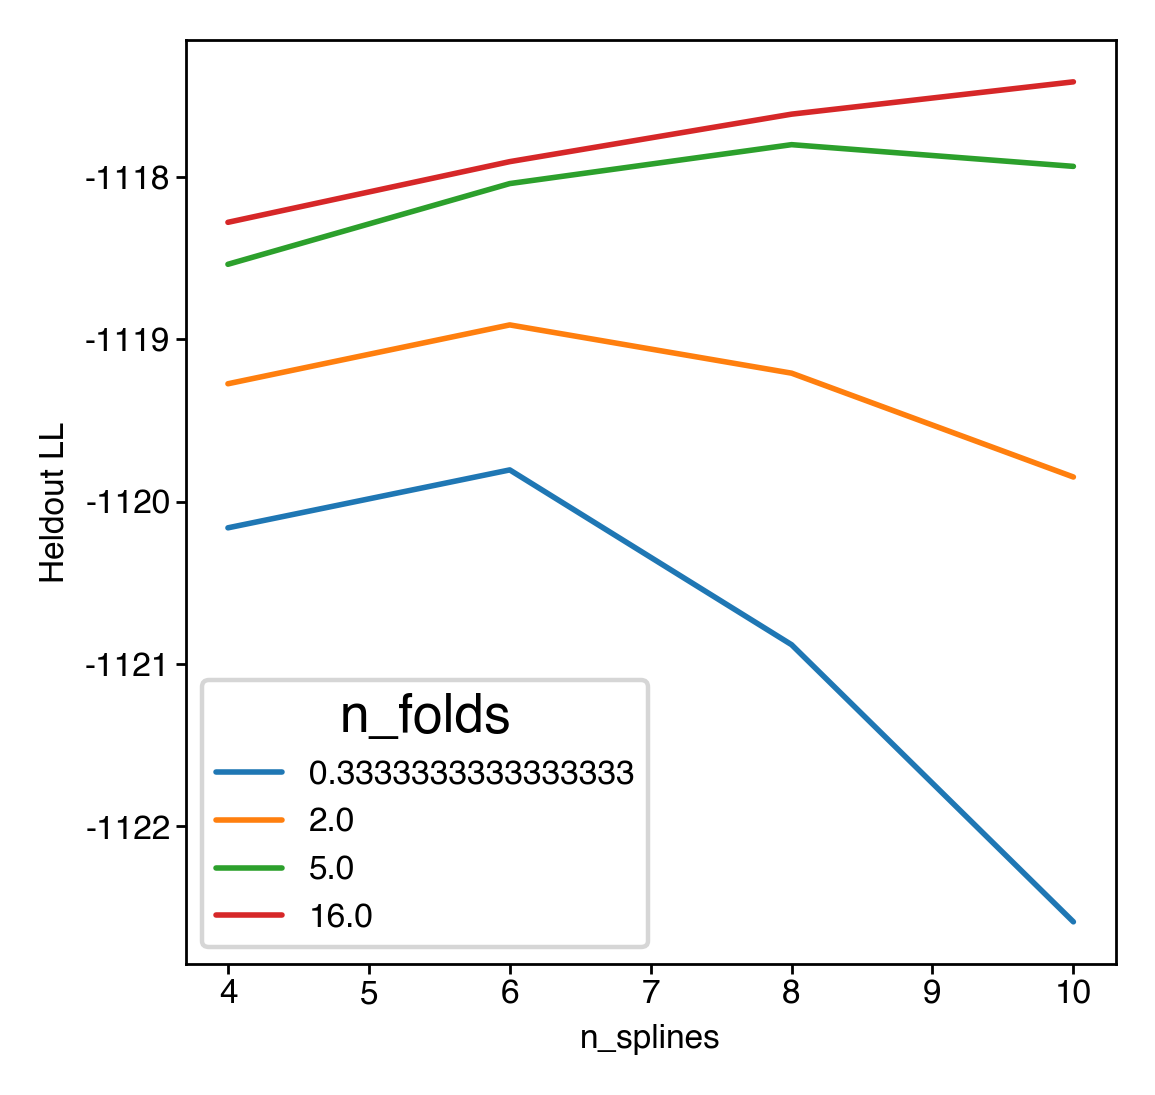

In [80]:
ax = pd.pivot_table(out, columns='n_folds', index='n_splines', values='heldout_ll').plot()
ax.set(ylabel='Heldout LL')

<Axes: xlabel='n_splines'>

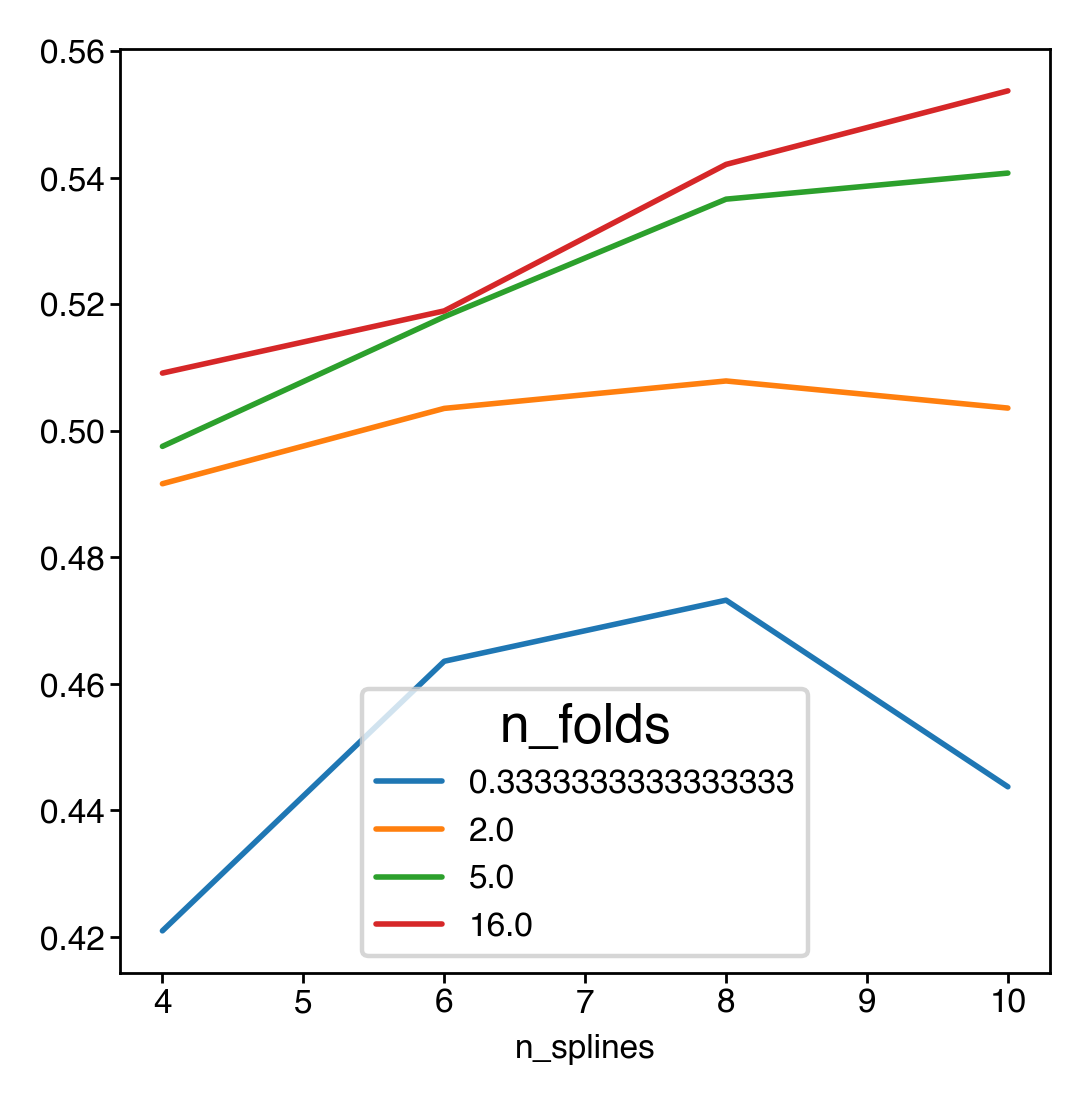

In [69]:
pd.pivot_table(out, columns='n_folds', index='n_splines', values='heldout_r2').plot()

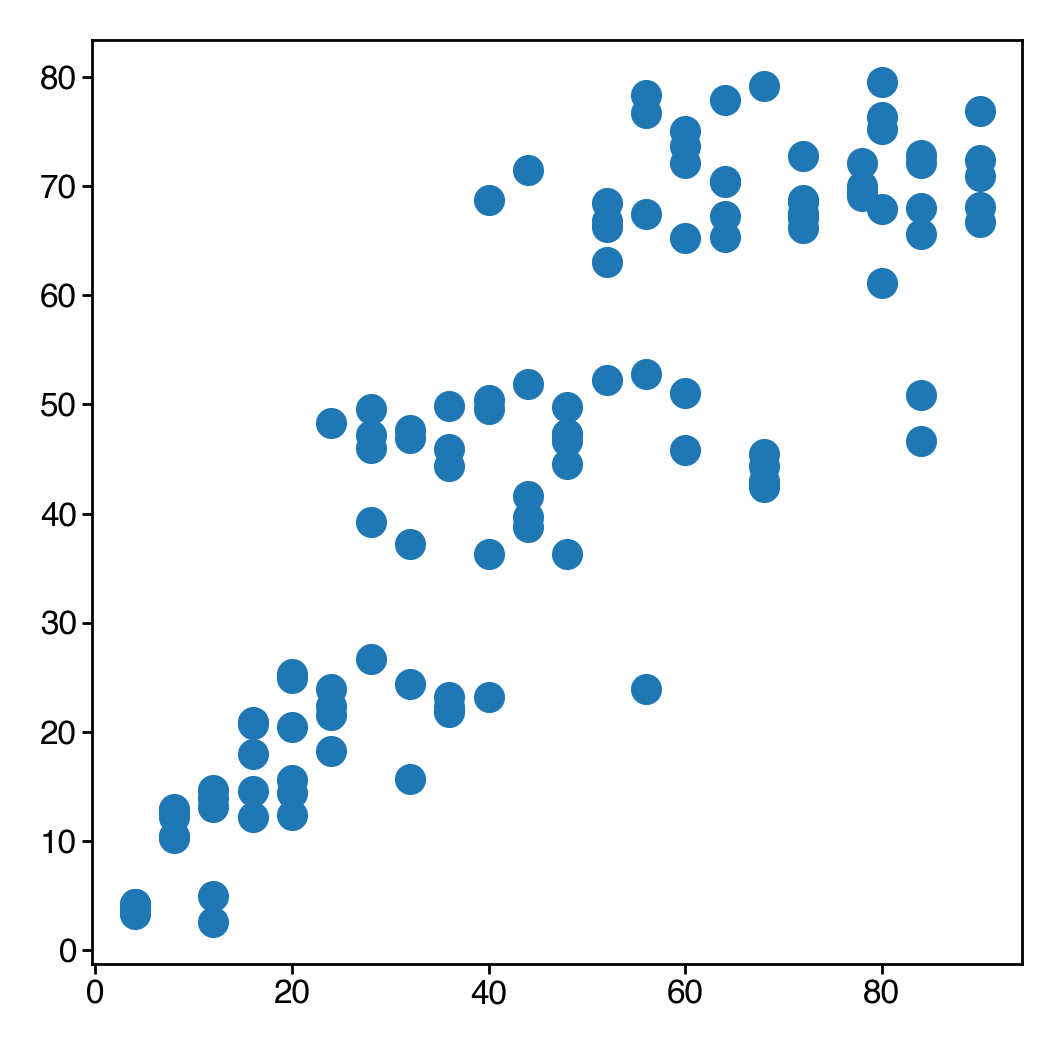

In [68]:
plt.scatter(tmp[0]['true_ages'], tmp[0]['bio_ages'])

In [77]:
hypparams["n_splines"] = 5
tmp = masked_xval(features, hypparams, 2, n_repeats=2, disable_tqdm=False)

  0%|          | 0/2 [00:00<?, ?it/s]

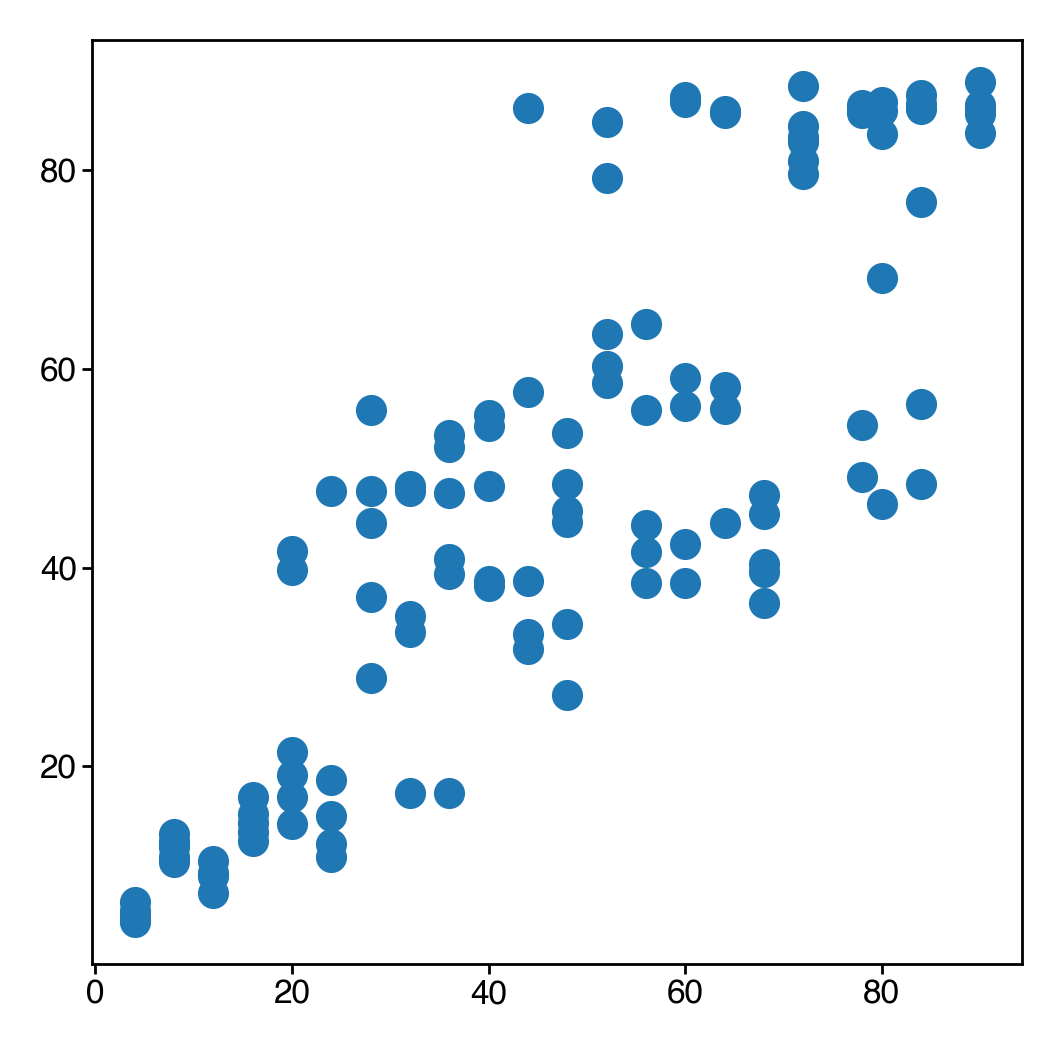

In [78]:
plt.scatter(tmp[0]['true_ages'], tmp[0]['bio_ages'])

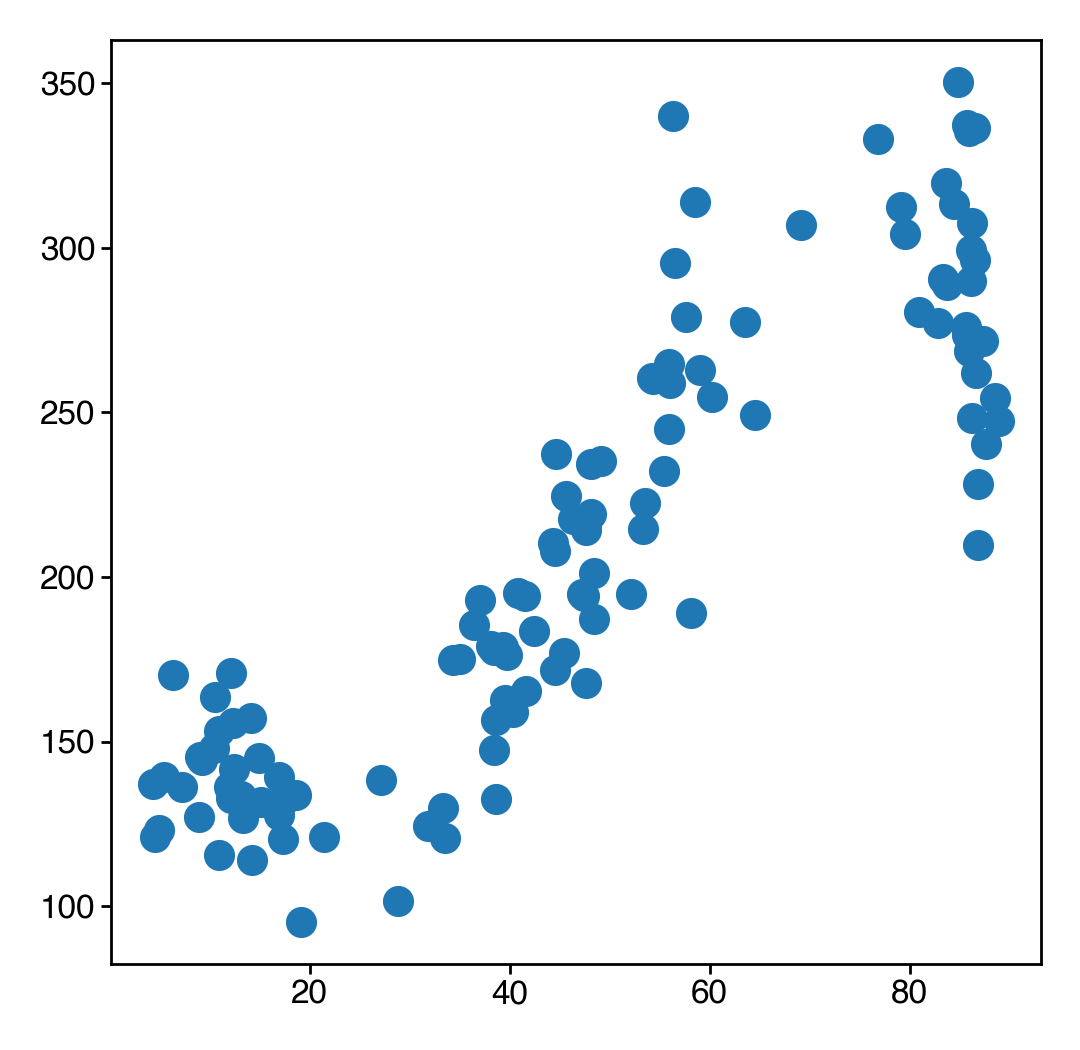

In [79]:
plt.scatter(tmp[0]['bio_ages'], tmp[0]['predicted_counts'][:, 0])

## Fit a "final" (lol) ontogeny model

In [86]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 100,
    "age_sd": 7,  # weeks
    # "bio_params_sd": 3,
    "size_params_sd": 1000,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_size_splines": 5,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.05,
    "n_opt_iter": 500,
    "use_rw_prior": False,
    "rw_sd": 100
}

In [87]:
tmp = masked_xval(features, hypparams, 2, n_repeats=10, disable_tqdm=False)

  0%|          | 0/10 [00:00<?, ?it/s]

In [88]:
!mkdir -p /n/scratch/users/w/wg41/bio-age-model/2024-04-11

/home/wg41/miniconda3/envs/aging-gpu/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [90]:
for v in tmp.values():
    v["init_components"].age_normalizer = None
    v["init_components"].age_unnormalizer = None

In [91]:
joblib.dump(
    tmp,
    "/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model.p"
)

['/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model.p']

In [95]:
out_dict = {}
for k, v in tmp.items():
    out_dict[f'bio_age_{k:02d}'] = v['bio_ages']
out_dict['age'] = tmp[0]['true_ages']
bio_age_df = pd.DataFrame(out_dict, index=df.index)

In [97]:
bio_age_df.to_parquet("/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model.parquet")

### Version 2

In [98]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 100,
    "age_sd": 20,  # weeks
    # "bio_params_sd": 3,
    "size_params_sd": 1000,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_size_splines": 5,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.05,
    "n_opt_iter": 500,
    "use_rw_prior": False,
    "rw_sd": 100
}

In [100]:
tmp = masked_xval(features, hypparams, 2, n_repeats=6, disable_tqdm=False)

  0%|          | 0/6 [00:00<?, ?it/s]

In [101]:
for v in tmp.values():
    v["init_components"].age_normalizer = None
    v["init_components"].age_unnormalizer = None

In [102]:
joblib.dump(
    tmp,
    "/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v2.p"
)

['/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v2.p']

In [103]:
out_dict = {}
for k, v in tmp.items():
    out_dict[f'bio_age_{k:02d}'] = v['bio_ages']
out_dict['age'] = tmp[0]['true_ages']
bio_age_df = pd.DataFrame(out_dict, index=df.index)

In [104]:
bio_age_df.to_parquet("/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v2.parquet")

### Version 3 - 5 splines

In [5]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 100,
    "age_sd": 20,  # weeks
    # "bio_params_sd": 3,
    "size_params_sd": 1000,
    "n_age_samples": 1000,
    "n_splines": 5,
    "n_size_splines": 5,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.05,
    "n_opt_iter": 500,
    "use_rw_prior": False,
    "rw_sd": 100
}

In [6]:
tmp = masked_xval(features, hypparams, 2, n_repeats=6, disable_tqdm=False)

  0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
for v in tmp.values():
    v["init_components"].age_normalizer = None
    v["init_components"].age_unnormalizer = None

In [8]:
joblib.dump(
    tmp,
    "/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v3.p"
)

['/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v3.p']

In [9]:
out_dict = {}
for k, v in tmp.items():
    out_dict[f'bio_age_{k:02d}'] = v['bio_ages']
out_dict['age'] = tmp[0]['true_ages']
bio_age_df = pd.DataFrame(out_dict, index=df.index)

In [10]:
bio_age_df.to_parquet("/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v3.parquet")

### Version 4 - 5 splines with bio params sd regularization

In [11]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 100,
    "age_sd": 20,  # weeks
    "bio_params_sd": 3,
    "size_params_sd": 1000,
    "n_age_samples": 1000,
    "n_splines": 5,
    "n_size_splines": 5,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.05,
    "n_opt_iter": 500,
    "use_rw_prior": False,
    "rw_sd": 100
}

In [12]:
tmp = masked_xval(features, hypparams, 2, n_repeats=6, disable_tqdm=False)

  0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
for v in tmp.values():
    v["init_components"].age_normalizer = None
    v["init_components"].age_unnormalizer = None

In [14]:
joblib.dump(
    tmp,
    "/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v4.p"
)

['/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v4.p']

In [15]:
out_dict = {}
for k, v in tmp.items():
    out_dict[f'bio_age_{k:02d}'] = v['bio_ages']
out_dict['age'] = tmp[0]['true_ages']
bio_age_df = pd.DataFrame(out_dict, index=df.index)

In [16]:
bio_age_df.to_parquet("/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v4.parquet")

### Version 5 - 5 splines with bio params sd regularization and low `age_sd`

In [17]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 100,
    "age_sd": 7,  # weeks
    "bio_params_sd": 3,
    "size_params_sd": 1000,
    "n_age_samples": 1000,
    "n_splines": 5,
    "n_size_splines": 5,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.05,
    "n_opt_iter": 500,
    "use_rw_prior": False,
    "rw_sd": 100
}

In [18]:
tmp = masked_xval(features, hypparams, 2, n_repeats=6, disable_tqdm=False)

  0%|          | 0/6 [00:00<?, ?it/s]

In [19]:
for v in tmp.values():
    v["init_components"].age_normalizer = None
    v["init_components"].age_unnormalizer = None

In [20]:
joblib.dump(
    tmp,
    "/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v5.p"
)

['/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v5.p']

In [21]:
out_dict = {}
for k, v in tmp.items():
    out_dict[f'bio_age_{k:02d}'] = v['bio_ages']
out_dict['age'] = tmp[0]['true_ages']
bio_age_df = pd.DataFrame(out_dict, index=df.index)

In [22]:
bio_age_df.to_parquet("/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v5.parquet")

## Compare normalizing via softmax

In [7]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 100,
    "age_sd": 9,  # weeks
    "n_age_samples": 1250,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "scale": 300,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.1,
    "n_opt_iter": 200,
}

In [27]:
hypparams['normalize_by_softmax'] = True
out = fit_model(features, hypparams, model_version=1)
out['r2_total']

0.5275198180784362

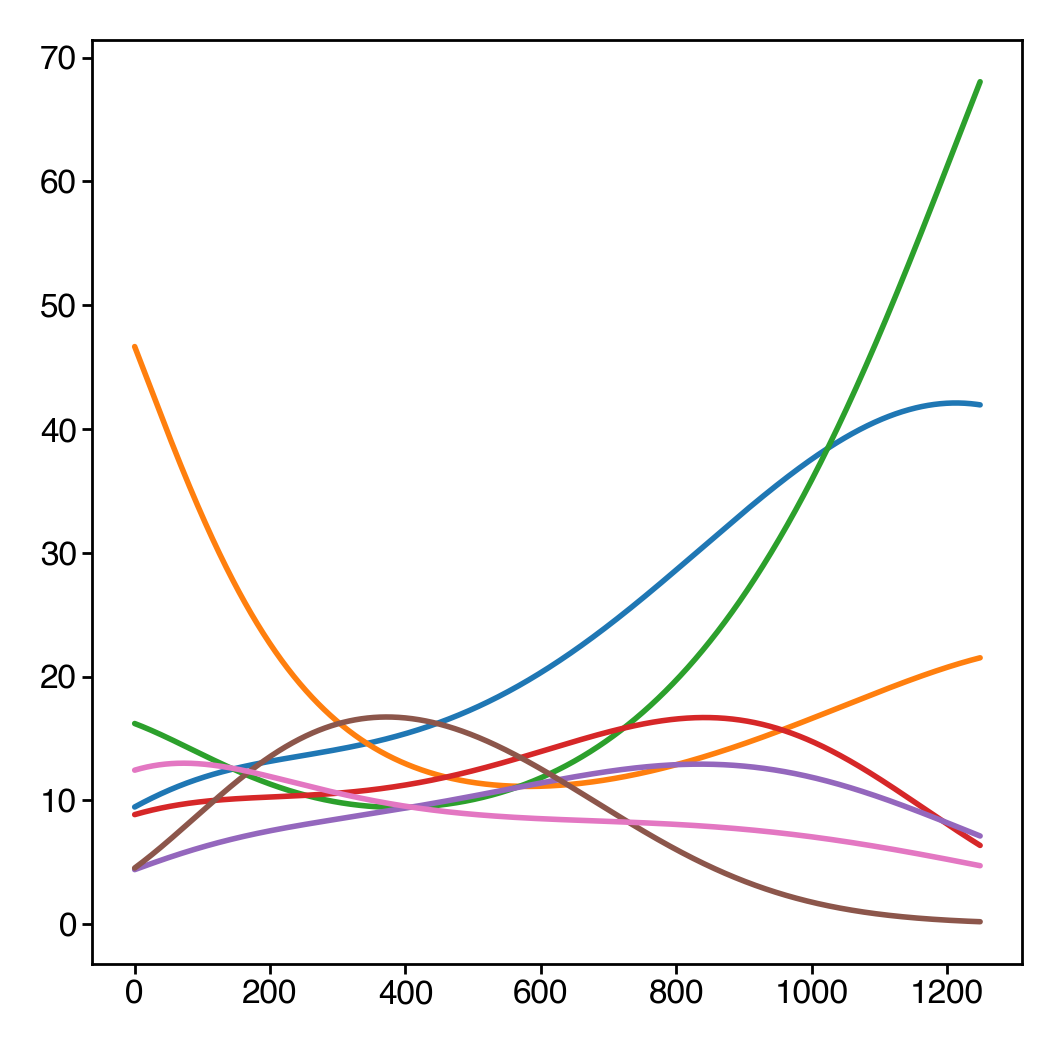

In [29]:
for i in range(7):
    plt.plot(out['concentrations'][0, :, sort_idx[i]])

In [30]:
hypparams['normalize_by_softmax'] = False
out = fit_model(features, hypparams, model_version=1)
out['r2_total']

0.5297140228224206

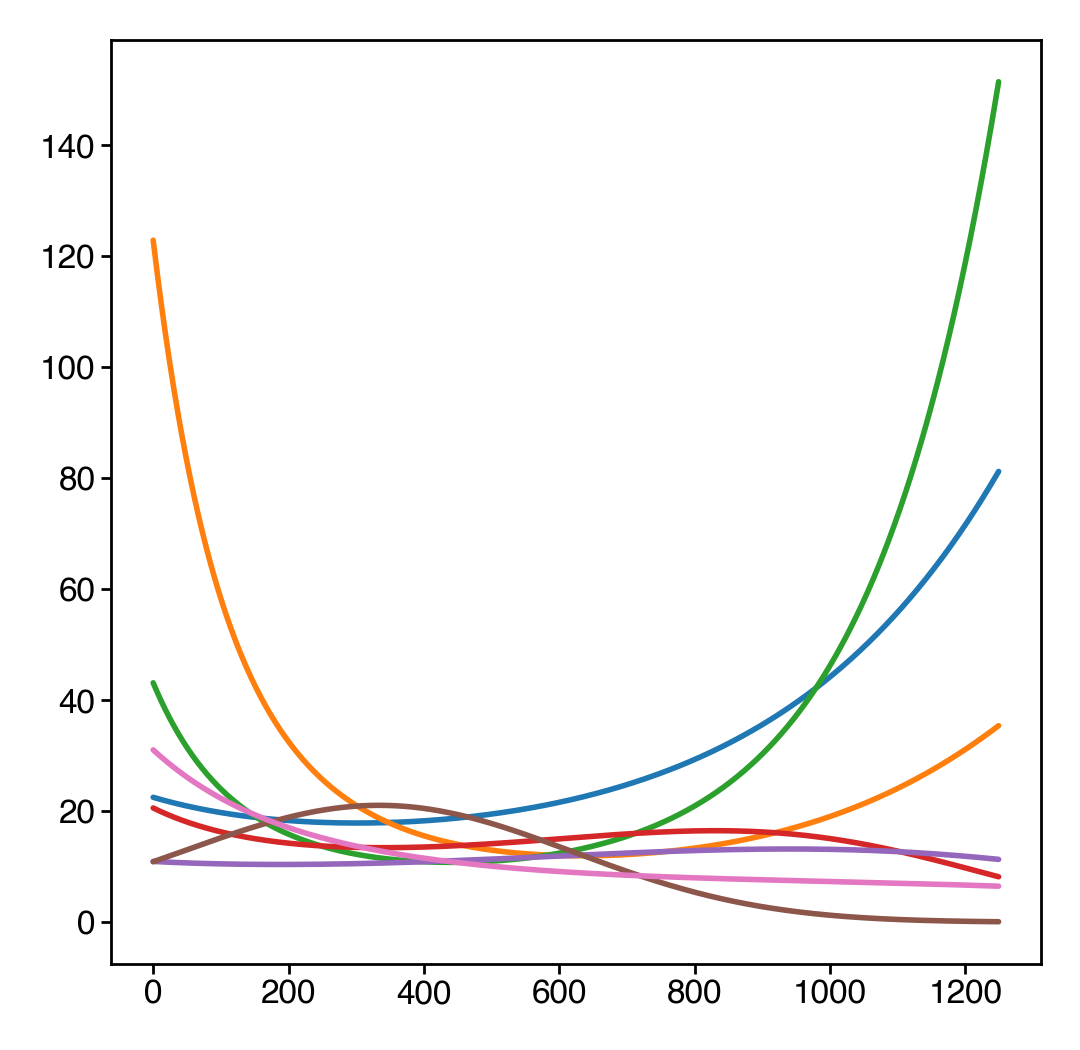

In [31]:
for i in range(7):
    plt.plot(out['concentrations'][0, :, sort_idx[i]])

In [39]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 100,
    "age_sd": 9,  # weeks
    "n_age_samples": 1250,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "scale": 1,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.1,
    "n_opt_iter": 200,
}

In [40]:
out = fit_model(features, hypparams, model_version=1)
out['r2_total']

-1.3827017543714413

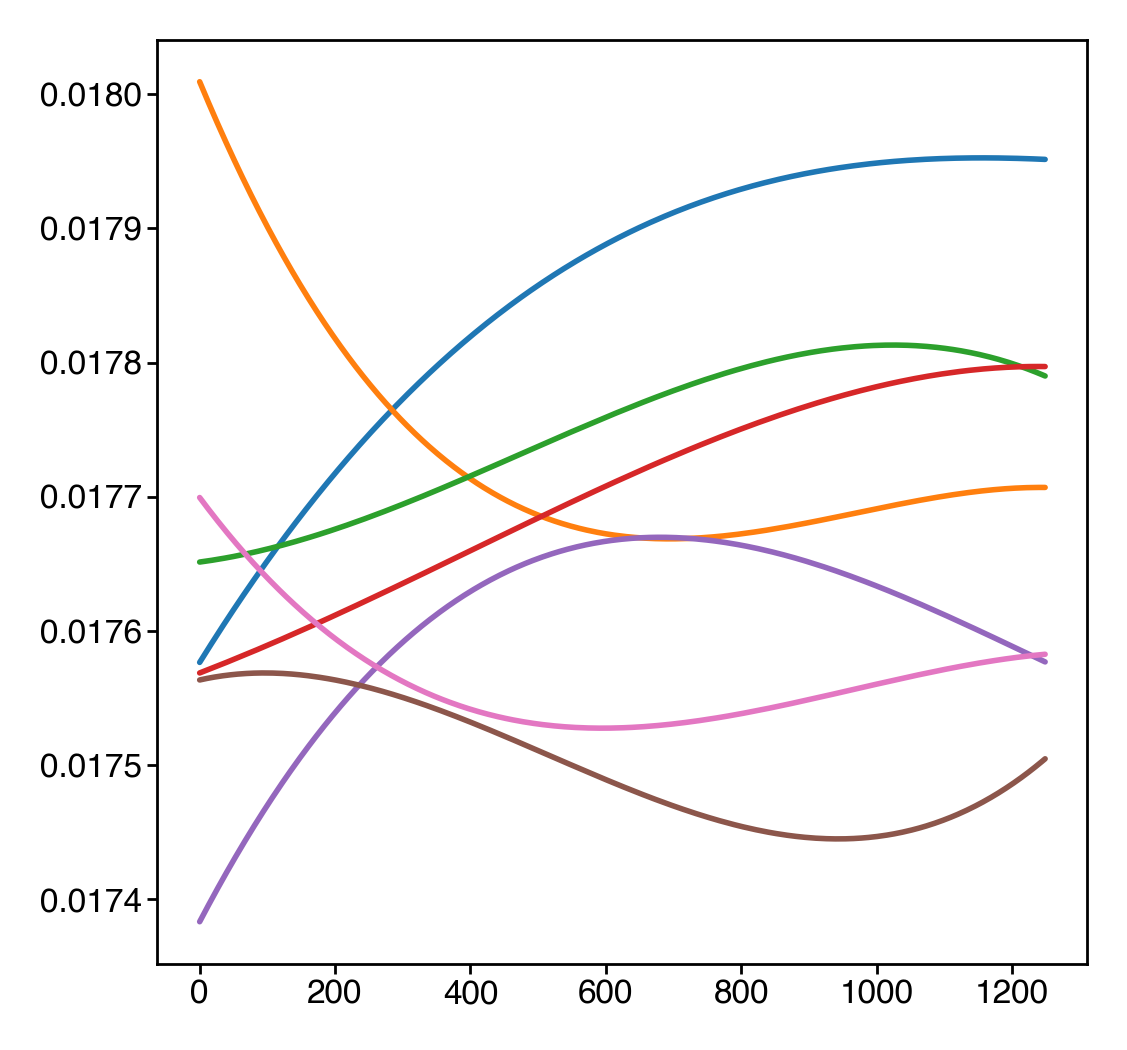

In [41]:
for i in range(7):
    plt.plot(out['concentrations'][0, :, sort_idx[i]])

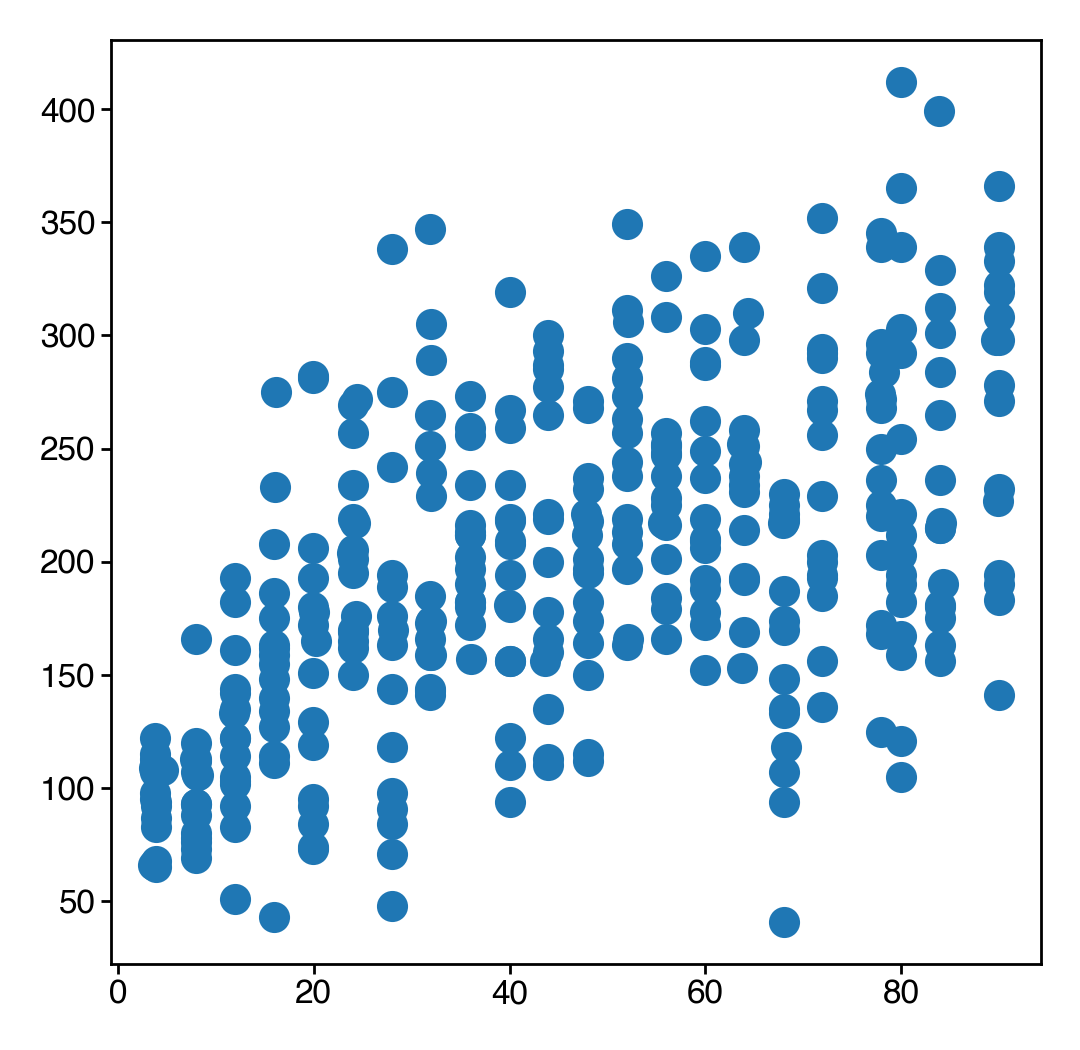

In [44]:
plt.scatter(out['bio_ages'], out['counts'][:, sort_idx[0]])

In [45]:
hypparams['scale'] = 100
out = fit_model(features, hypparams, model_version=1)
out['r2_total']

0.40515219059297597

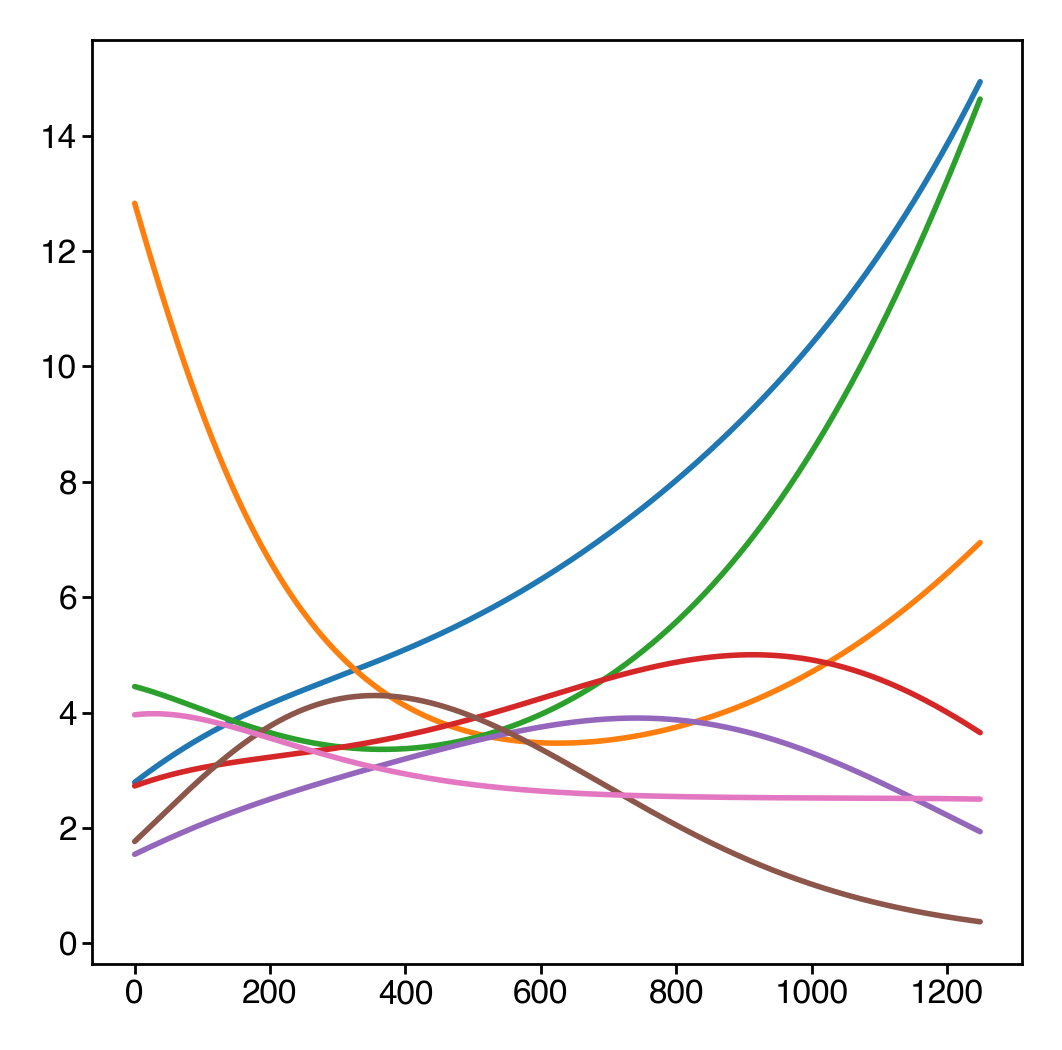

In [46]:
for i in range(7):
    plt.plot(out['concentrations'][0, :, sort_idx[i]])

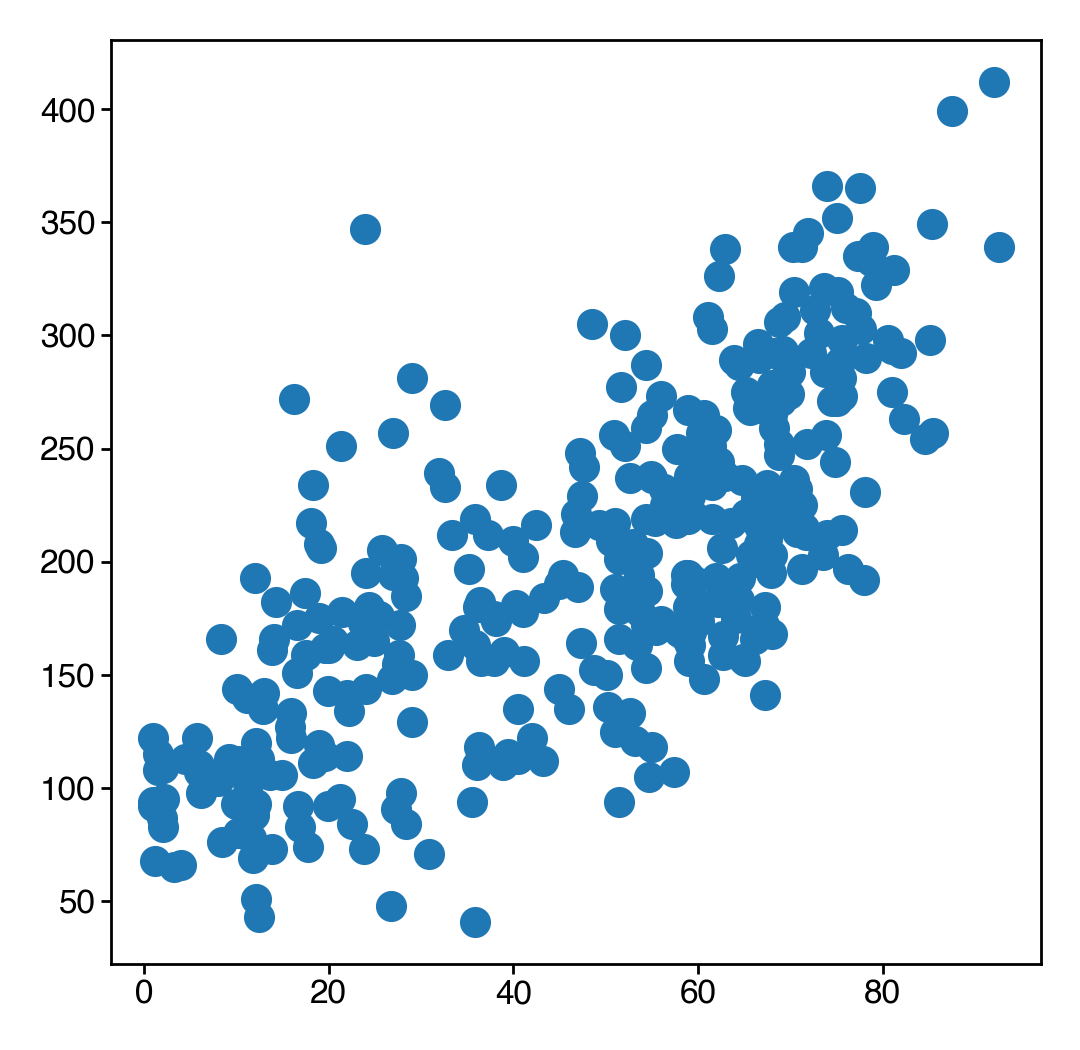

In [47]:
plt.scatter(out['bio_ages'], out['counts'][:, sort_idx[0]])